In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun  7 18:36:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Construct Env using **Maria's code** 👍

Since I extracted only 1 episode (300 trial) from Maria's MATLAB experimental code,

This section only consists of agents that went through 1 episode.

### Mount Google Drive

In [ ]:
from IPython import get_ipython
from IPython.display import display
import os
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# CSV 파일 경로 수정
csv_path = '/content/drive/MyDrive/eel_trial_summary.csv'
df = pd.read_csv(csv_path)

Mounted at /content/drive


### 1. Random Policy

총 reward: 92


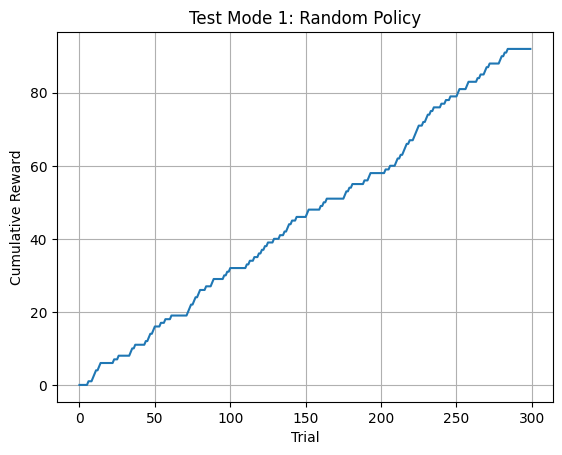

In [ ]:
class EelEnv:
    def __init__(self, trial_data):
        self.trials = trial_data
        self.current_trial = 0
        self.done = False

    def reset(self):
        self.current_trial = 0
        self.done = False
        return self.get_state()

    def step(self, action):
        if self.done:
            return self.get_state(), 0, True, {}

        row = self.trials.iloc[self.current_trial]
        if action == 0:
            comp = row['left_competency']
            rel = row['left_reliability']
        else:
            comp = row['right_competency']
            rel = row['right_reliability']

        # 물고기 수 샘플링 (competency 기반 평균)
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))

        # reward 확률: P(reward = 1) = min(1, reliability * n_fish)
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)

        self.current_trial += 1
        if self.current_trial >= len(self.trials):
            self.done = True

        return np.array([n_fish]), reward, self.done, {}

    def get_state(self):
        return np.array([0])  # Test 1에서는 dummy state 사용

env = EelEnv(df)
state = env.reset()
done = False
total_reward = 0
reward_history = []

while not done:
    action = np.random.choice([0, 1])  # random policy
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    reward_history.append(reward)
    state = next_state

print(f"총 reward: {total_reward}")

# 4. 보상 시각화
plt.plot(np.cumsum(reward_history))
plt.xlabel("Trial")
plt.ylabel("Cumulative Reward")
plt.title("Test Mode 1: Random Policy")
plt.grid(True)
plt.show()

### 2. SARSA Agent [state: last_n_fish] [state: last_n_fish, bayesian]

단일 episode 총 reward: 73


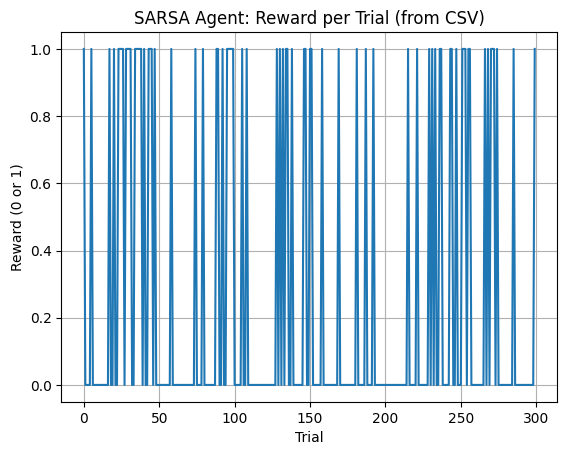

In [ ]:
# Reinforcement Learning Test 2: SARSA with Fish Count Only (single episode from CSV)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 환경 정의 (EelEnv)
class EelEnv:
    def __init__(self, trial_data):
        self.trials = trial_data
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        return self.get_state()

    def step(self, action):
        if self.done:
            return self.get_state(), 0, True, {}

        row = self.trials.iloc[self.current_trial]
        if action == 0:
            comp = row['left_competency']
            rel = row['left_reliability']
        else:
            comp = row['right_competency']
            rel = row['right_reliability']

        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)

        self.last_n_fish = n_fish
        self.current_trial += 1
        if self.current_trial >= len(self.trials):
            self.done = True

        return self.get_state(), reward, self.done, {}

    def get_state(self):
        return np.array([self.last_n_fish])


# 2. 데이터 로드 (하나의 episode만 사용)
env = EelEnv(df)

# 3. SARSA 초기화
n_states = (4,)
n_actions = 2
Q = np.zeros(n_states + (n_actions,))

epsilon = 0.1
alpha = 0.1
gamma = 0.9

# 4. 학습 루프 (1 episode)
state = env.reset()
n_fish = state[0].astype(int)
action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[n_fish])
done = False
total_reward = 0
reward_trajectory = []

while not done:
    next_state, reward, done, _ = env.step(action)
    next_n_fish = next_state[0].astype(int)
    next_action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[next_n_fish])

    Q[n_fish, action] += alpha * (
        reward + gamma * Q[next_n_fish, next_action] - Q[n_fish, action]
    )

    n_fish = next_n_fish
    action = next_action
    total_reward += reward
    reward_trajectory.append(reward)

print(f"단일 episode 총 reward: {total_reward}")

# 5. 보상 시각화
plt.plot(reward_trajectory)
plt.xlabel("Trial")
plt.ylabel("Reward (0 or 1)")
plt.title("SARSA Agent: Reward per Trial (from CSV)")
plt.grid(True)
plt.show()


단일 episode 총 reward: 73


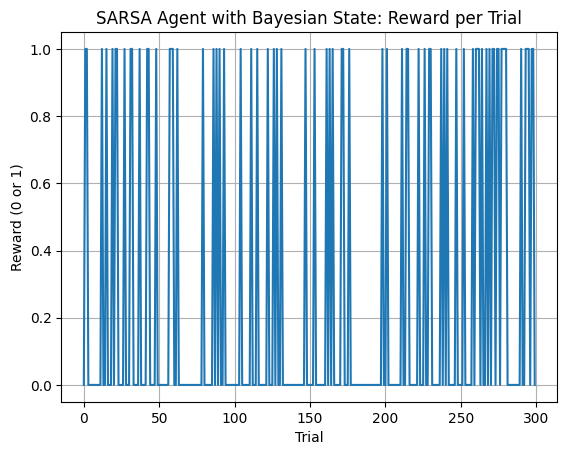

In [ ]:
# Reinforcement Learning Test 3: SARSA with Bayesian Inference (single episode from CSV)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 환경 정의 (EelEnv + Bayesian 추론 포함)
class EelEnv:
    def __init__(self, trial_data):
        self.trials = trial_data
        self.current_trial = 0
        self.done = False
        self.left_rewards = []  # 왼쪽 선택 후 보상 여부 기록
        self.right_rewards = []  # 오른쪽 선택 후 보상 여부 기록

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.left_rewards = []
        self.right_rewards = []
        return self.get_state()

    def compute_posterior(self, rewards, high=0.25, low=0.10):
        if not rewards:
            return 0.5  # prior
        lh_high = np.prod([high if r else 1 - high for r in rewards])
        lh_low = np.prod([low if r else 1 - low for r in rewards])
        return lh_high / (lh_high + lh_low) if (lh_high + lh_low) > 0 else 0.5

    def step(self, action):
        if self.done:
            return self.get_state(), 0, True, {}

        row = self.trials.iloc[self.current_trial]
        if action == 0:
            comp = row['left_competency']
            rel = row['left_reliability']
        else:
            comp = row['right_competency']
            rel = row['right_reliability']

        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)

        # 보상 결과 기록
        if action == 0:
            self.left_rewards.append(reward)
        else:
            self.right_rewards.append(reward)

        self.current_trial += 1
        if self.current_trial >= len(self.trials):
            self.done = True

        return self.get_state(), reward, self.done, {}

    def get_state(self):
        # 각 eel이 high reliability일 확률을 Bayesian 추론으로 계산
        left_p = self.compute_posterior(self.left_rewards)
        right_p = self.compute_posterior(self.right_rewards)
        return np.array([left_p, right_p])


# 2. 데이터 로드 (하나의 episode만 사용)
env = EelEnv(df)

# 3. SARSA 초기화
n_states = (11, 11)  # 확률값을 0.0~1.0까지 0.1 간격으로 양자화 (총 11단계)
n_actions = 2
Q = np.zeros(n_states + (n_actions,))

def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))

epsilon = 0.1
alpha = 0.1
gamma = 0.9

# 4. 학습 루프 (1 episode)
state = env.reset()
q_state = tuple(map(quantize, state))
action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[q_state])
done = False
total_reward = 0
reward_trajectory = []

while not done:
    next_state, reward, done, _ = env.step(action)
    next_q_state = tuple(map(quantize, next_state))
    next_action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[next_q_state])

    Q[q_state + (action,)] += alpha * (
        reward + gamma * Q[next_q_state + (next_action,)] - Q[q_state + (action,)]
    )

    q_state = next_q_state
    action = next_action
    total_reward += reward
    reward_trajectory.append(reward)

print(f"단일 episode 총 reward: {total_reward}")

# 5. 보상 시각화
plt.plot(reward_trajectory)
plt.xlabel("Trial")
plt.ylabel("Reward (0 or 1)")
plt.title("SARSA Agent with Bayesian State: Reward per Trial")
plt.grid(True)
plt.show()


# Construct Env with own code ⚡

### Import libraries and generate trial info (competency/reliability for each eel) + visualization function

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def generate_trials(n_trials=300, rel_mu=25, rel_sigma=2, comp_mu=8, comp_sigma=1):
    comps = [0.4, 0.55, 0.7, 0.9]
    trials = []

    # 초기 competency와 reliability 설정
    left_comp, right_comp = np.random.choice(comps, 2, replace=False)
    left_rel = 0.25
    right_rel = 0.10

    # 초기 reliability swap 여부 결정
    if np.random.rand() < 0.5:
        left_rel, right_rel = right_rel, left_rel
        initial_rel_swap = True
    else:
        initial_rel_swap = False

    comp_change_points = [0]
    rel_change_points = []

    # 초기 다음 변화 시점 설정
    next_rel_swap = int(np.clip(np.random.normal(rel_mu, rel_sigma), 5, n_trials - 1))
    next_comp_swap = int(np.clip(np.random.normal(comp_mu, comp_sigma), 3, n_trials - 1))

    t = 0
    while t < n_trials:
        # competency 갱신
        if t == next_comp_swap:
            # 서로 다른 competency 2개 뽑기
            left_comp, right_comp = np.random.choice(comps, 2, replace=False)
            comp_change_points.append(t)

            # 다음 swap 시점 설정
            offset = int(np.clip(np.random.normal(comp_mu, comp_sigma), 3, n_trials - t - 1))
            next_comp_swap = t + offset

        # reliability swap 시점 도달 시 swap
        if t == next_rel_swap:
            left_rel, right_rel = right_rel, left_rel
            rel_change_points.append(t)

            offset = int(np.clip(np.random.normal(rel_mu, rel_sigma), 5, n_trials - t - 1))
            next_rel_swap = t + offset

        trials.append({
            'left_competency': left_comp,
            'right_competency': right_comp,
            'left_reliability': left_rel,
            'right_reliability': right_rel
        })

        t += 1

    return pd.DataFrame(trials), comp_change_points, rel_change_points


# 테스트 실행
trialinfo, comp_changes, rel_changes = generate_trials()

print(trialinfo)
print("Competency change points:", comp_changes)
print("Reliability change points:", rel_changes)

     left_competency  right_competency  left_reliability  right_reliability
0               0.70              0.55              0.10               0.25
1               0.70              0.55              0.10               0.25
2               0.70              0.55              0.10               0.25
3               0.70              0.55              0.10               0.25
4               0.70              0.55              0.10               0.25
..               ...               ...               ...                ...
295             0.55              0.40              0.25               0.10
296             0.55              0.40              0.25               0.10
297             0.55              0.40              0.25               0.10
298             0.55              0.40              0.25               0.10
299             0.55              0.70              0.10               0.25

[300 rows x 4 columns]
Competency change points: [0, 8, 15, 21, 29, 37, 45, 52, 61, 71,

In [5]:
# -------- Visualization --------
def visualize_episode(df, comp_changes, rel_changes, actions, rewards, ep_num):
    plt.figure(figsize=(12, 5))
    plt.plot(rewards, label='Reward', color='gray', alpha=0.5)

    rel_opt_list = []
    comp_opt_list = []

    for t, a in enumerate(actions):
        row = df.iloc[t]
        left_comp, right_comp = row['left_competency'], row['right_competency']
        left_rel, right_rel = row['left_reliability'], row['right_reliability']

        opt_comp = 0 if left_comp > right_comp else 1
        opt_rel = 0 if left_rel > right_rel else 1
        rel_opt_list.append(opt_rel)
        comp_opt_list.append(opt_comp)

        plt.plot(t, 1.1, 'b_' if a == 0 else 'r_', linewidth=3)
        plt.plot(t, 1.2, 'b_' if opt_comp == 0 else 'r_', linewidth=3)
        plt.plot(t, 1.3, 'b_' if opt_rel == 0 else 'r_', linewidth=3)

    for x in comp_changes:
        plt.axvline(x + 0.5, color='gold', linestyle='--', label='Comp Change' if x == comp_changes[0] else "")
    for x in rel_changes:
        plt.axvline(x + 0.5, color='purple', linestyle='--', label='Rel Change' if x == rel_changes[0] else "")

    plt.title(f"Episode {ep_num}: Reward + Action vs Competency/Rel Optimal")
    plt.xlabel("Trial")
    plt.ylim(-0.1, 1.5)
    plt.yticks([1.1, 1.2, 1.3], ['Action', 'Comp Optimal', 'Rel Optimal'])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 🔍 추가: Action과 Reliability Optimal 일치 비율 계산
    total = len(actions)
    correct = sum([a == ro for a, ro in zip(actions, rel_opt_list)])
    ratio = correct / total if total > 0 else 0
    print(f"[Episode {ep_num}] Action matches Rel Optimal: {correct}/{total} = {ratio:.2%}")

    # 🔍 추가: Action과 Competency Optimal 일치 비율 계산
    correct = sum([a == ro for a, ro in zip(actions, comp_opt_list)])
    ratio = correct / total if total > 0 else 0
    print(f"[Episode {ep_num}] Action matches Comp Optimal: {correct}/{total} = {ratio:.2%}")


### 👎 1. SARSA agent [state: last_n_fish] - # of fish caught on last trial

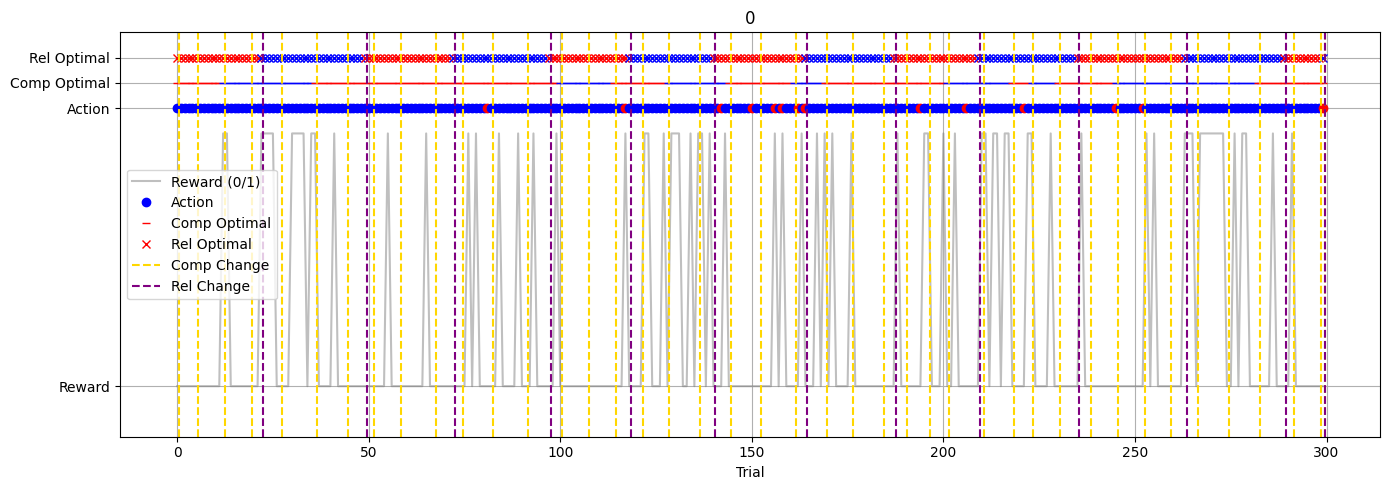

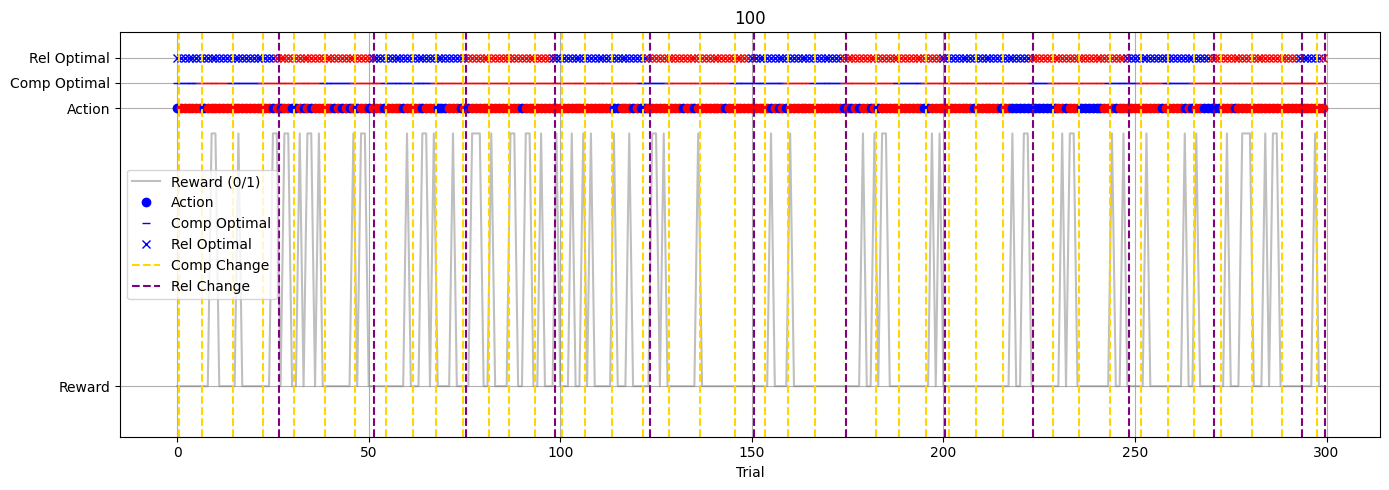

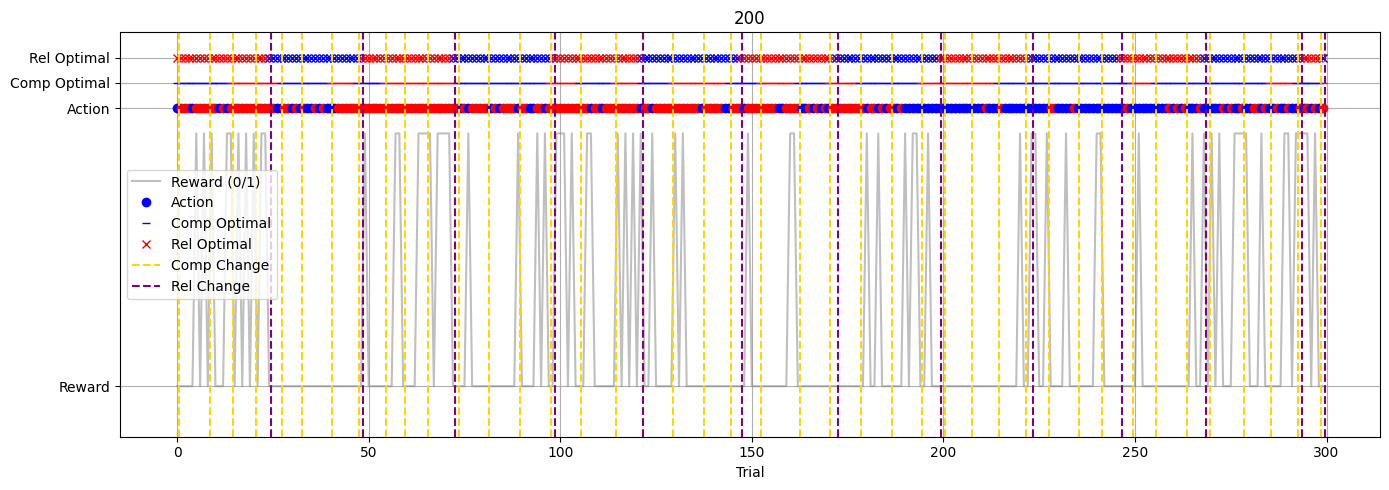

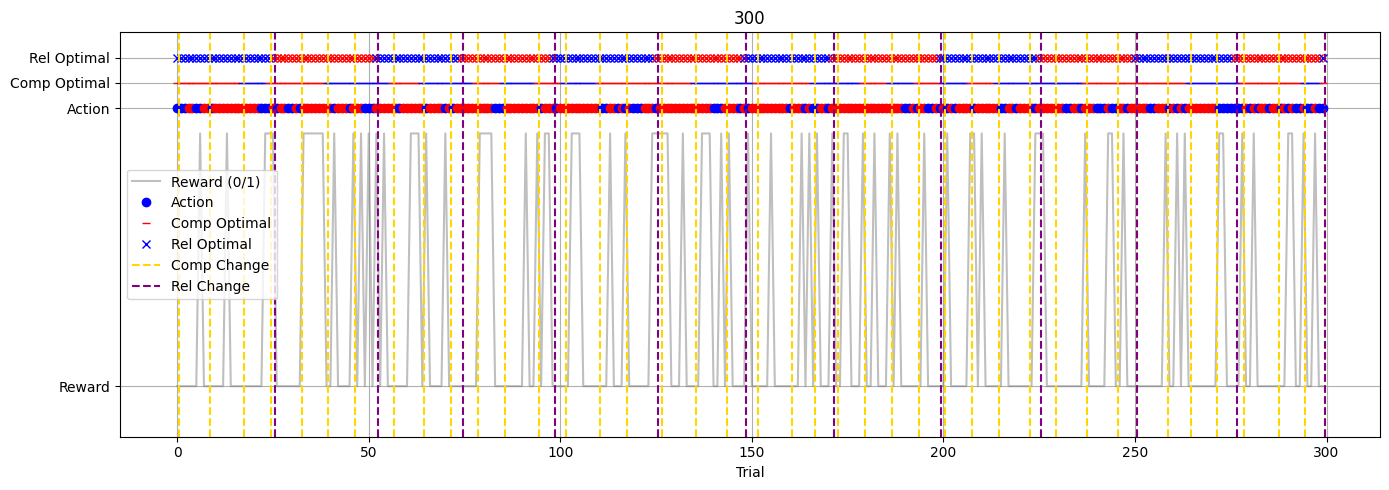

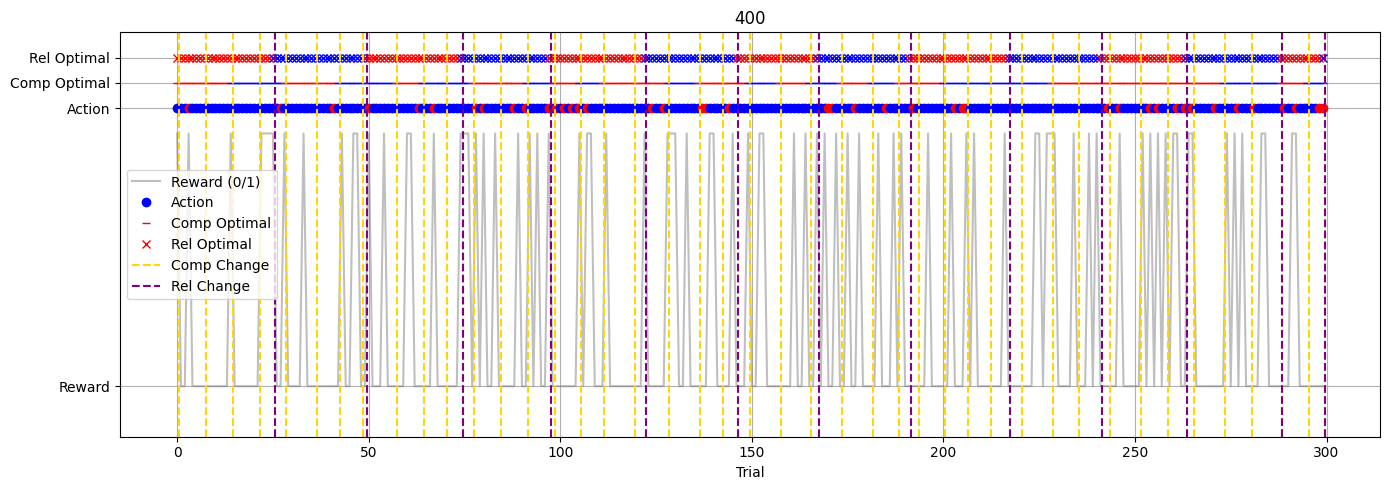

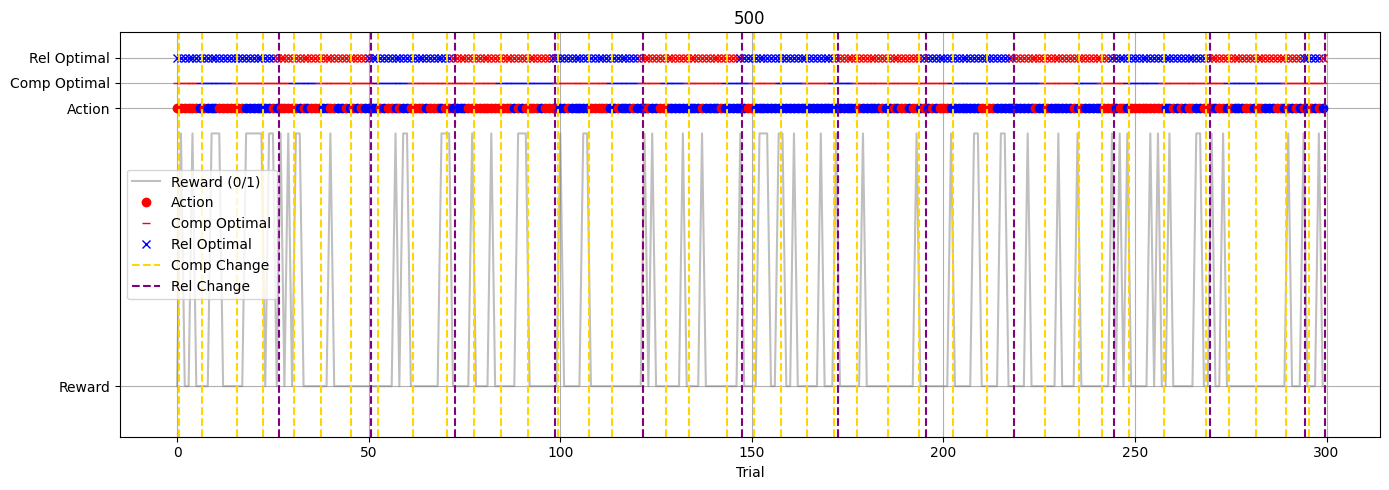

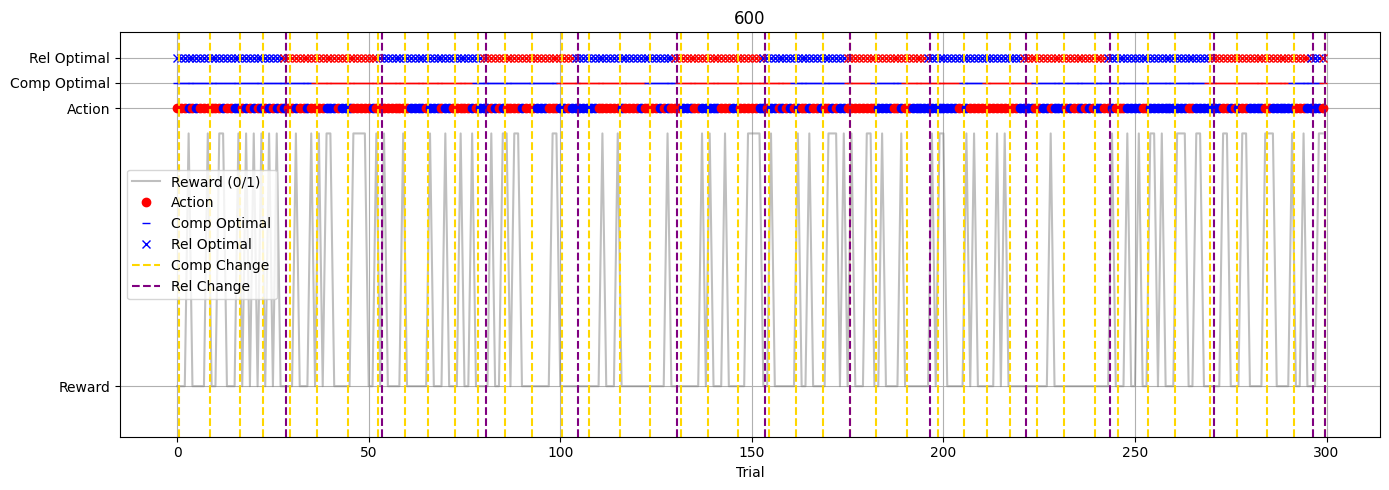

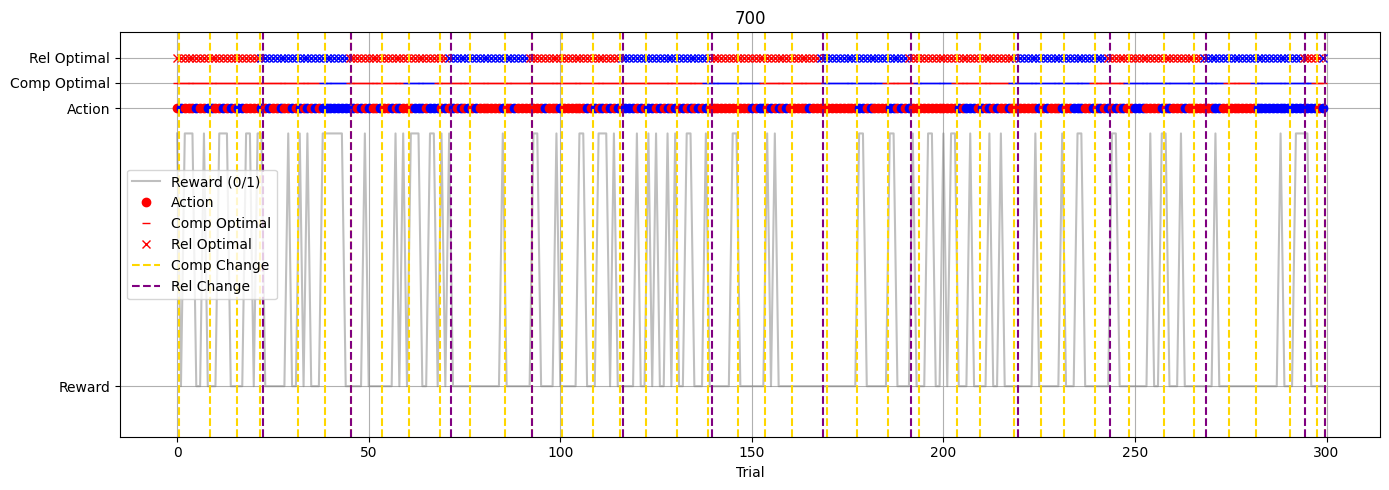

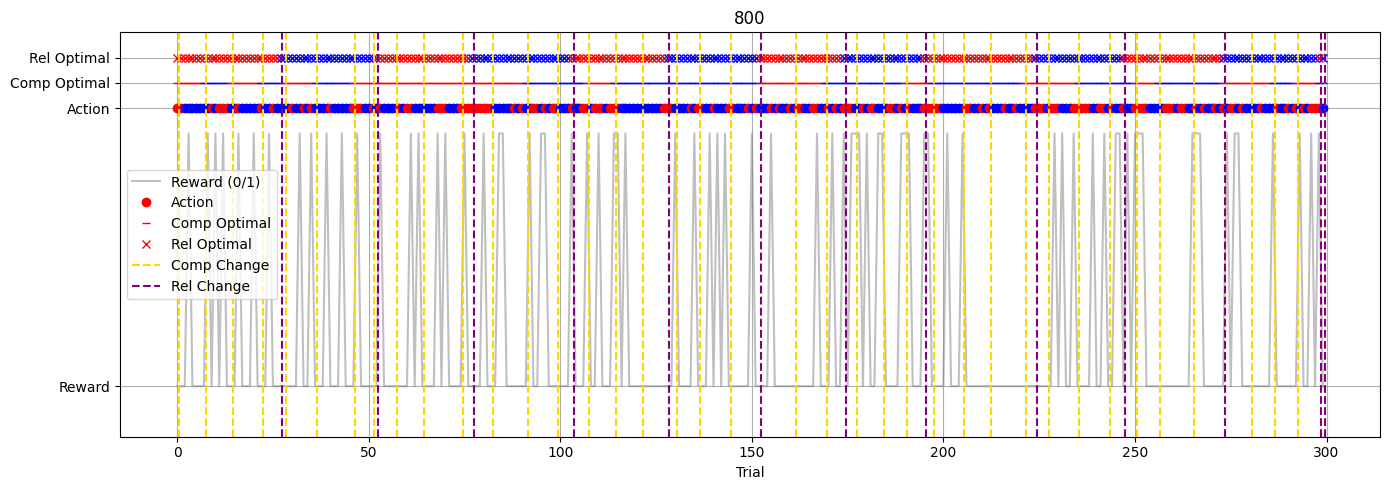

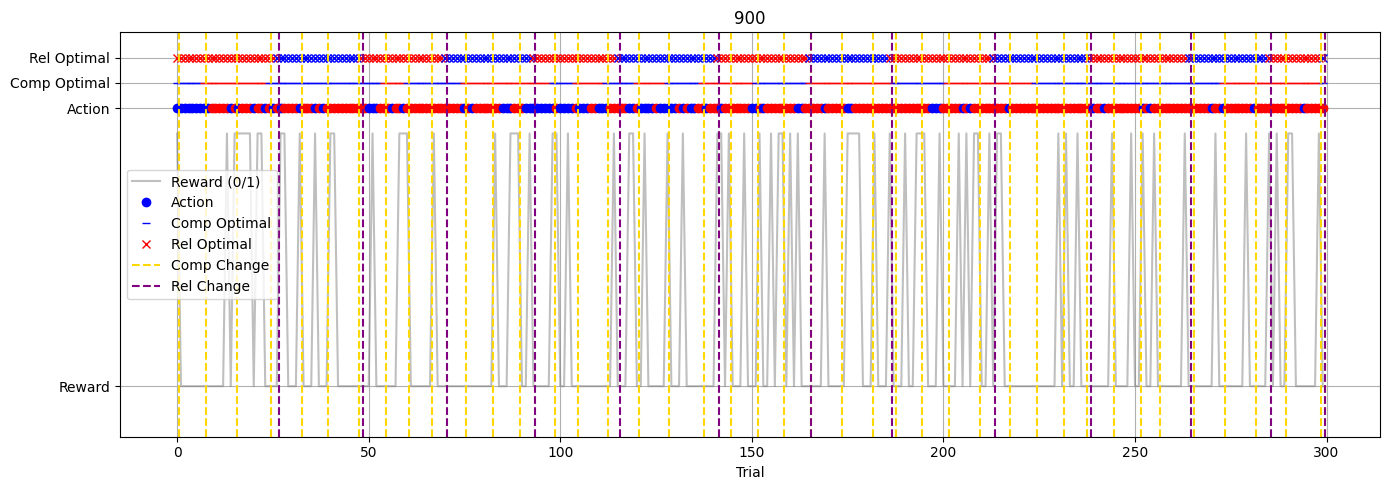

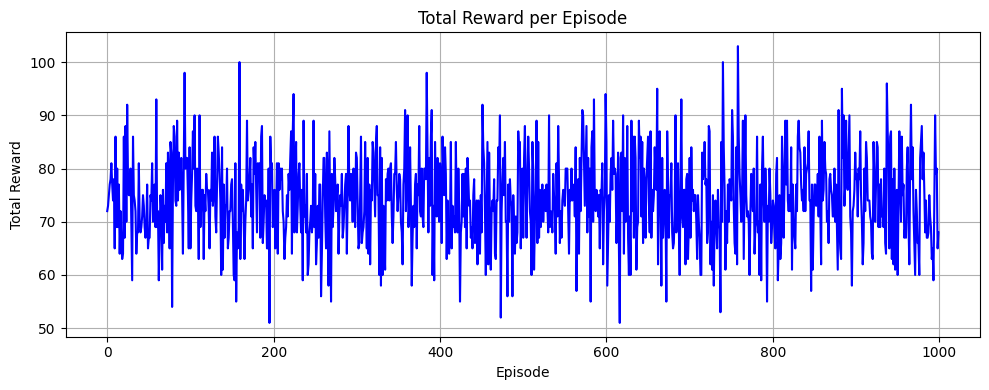

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class EelEnv:
    def __init__(self, trials):
        self.trials = trials
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        return self.get_state()

    def step(self, action):
        row = self.trials.iloc[self.current_trial]
        comp = row['left_competency'] if action == 0 else row['right_competency']
        rel = row['left_reliability'] if action == 0 else row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        self.last_n_fish = n_fish
        self.current_trial += 1
        if self.current_trial >= len(self.trials):
            self.done = True
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        return np.array([self.last_n_fish])

# 3. 시각화 함수
def visualize_episode(df, comp_changes, rel_changes, actions, rewards, title="Episode"):
    comp_optimal = []
    rel_optimal = []
    for t in range(len(df)):
        row = df.iloc[t]
        comp_optimal.append(0 if row['left_competency'] > row['right_competency'] else 1)
        rel_optimal.append(0 if row['left_reliability'] > row['right_reliability'] else 1)

    plt.figure(figsize=(14, 5))
    plt.plot(rewards, label='Reward (0/1)', color='gray', alpha=0.5)

    for t in range(len(actions)):
        a = actions[t]
        plt.plot(t, 1.1, 'bo' if a == 0 else 'ro', label='Action' if t == 0 else "")
        plt.plot(t, 1.2, 'b_' if comp_optimal[t] == 0 else 'r_', label='Comp Optimal' if t == 0 else "")
        plt.plot(t, 1.3, 'bx' if rel_optimal[t] == 0 else 'rx', label='Rel Optimal' if t == 0 else "")

    for x in comp_changes:
        plt.axvline(x + 0.5, color='gold', linestyle='--', label='Comp Change' if x == comp_changes[0] else "")
    for x in rel_changes:
        plt.axvline(x + 0.5, color='purple', linestyle='--', label='Rel Change' if x == rel_changes[0] else "")

    plt.yticks([0, 1.1, 1.2, 1.3], ['Reward', 'Action', 'Comp Optimal', 'Rel Optimal'])
    plt.title(title)
    plt.xlabel("Trial")
    plt.ylim(-0.2, 1.4)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4. 학습 설정
n_states = (4,)
n_actions = 2
Q = np.zeros(n_states + (n_actions,))
epsilon = 0.1
alpha = 0.1
gamma = 0.9
n_episodes = 300
avg_rewards = []
episode_plots = {}

# 5. 학습 루프
for ep in range(n_episodes):
    df, comp_changes, rel_changes = generate_trials()
    env = EelEnv(df)
    state = env.reset()
    n_fish = state[0].astype(int)
    action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[n_fish])
    done = False
    ep_reward = 0
    actions = []
    rewards = []

    while not done:
        next_state, reward, done, _ = env.step(action)
        next_n_fish = next_state[0].astype(int)
        next_action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[next_n_fish])
        Q[n_fish, action] += alpha * (reward + gamma * Q[next_n_fish, next_action] - Q[n_fish, action])
        actions.append(action)
        rewards.append(reward)
        n_fish = next_n_fish
        action = next_action
        ep_reward += reward

    avg_rewards.append(ep_reward)
    if ep % 100 == 0:
       # 수정된 정답
        episode_plots[ep] = (df, comp_changes, rel_changes, actions, rewards)

# -------- Plot Results --------
for ep, (df, comp_changes, rel_changes, actions, rewards) in episode_plots.items():
    visualize_episode(df, comp_changes, rel_changes, actions, rewards, ep)

plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.grid(True)
plt.tight_layout()
plt.show()


### 2. SARSA agent [state: bayesian reliability] - reliability of left/right eel based on reward

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -------- Environment --------
class EelEnv:
    def __init__(self, trials):
        self.trials = trials
        self.current_trial = 0
        self.done = False
        self.trial_log = []

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.trial_log = []
        return self.get_state()

    def compute_side_posteriors(self, memory_window=7, high=0.25, low=0.10):
        recent = self.trial_log[-memory_window:]
        lh_h1, lh_h2 = 1.0, 1.0  # left high, right low / left low, right high
        for action, reward in recent:
            rel_h1 = high if action == 0 else low
            rel_h2 = low  if action == 0 else high
            lh_h1 *= rel_h1 if reward else (1 - rel_h1)
            lh_h2 *= rel_h2 if reward else (1 - rel_h2)
        total = lh_h1 + lh_h2
        return (lh_h1 / total, lh_h2 / total) if total > 0 else (0.5, 0.5)

    def step(self, action):
        row = self.trials.iloc[self.current_trial]
        comp = row['left_competency'] if action == 0 else row['right_competency']
        rel = row['left_reliability'] if action == 0 else row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        self.trial_log.append((action, reward))
        self.current_trial += 1
        self.done = self.current_trial >= len(self.trials)
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        lp, rp = self.compute_side_posteriors()
        return np.array([lp, rp])

# -------- Utility --------
def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))



# -------- Training --------
n_states = (1, 11, 11)  # n_fish dimension 제거 (0~0 한 칸만 사용)
Q = np.zeros(n_states + (2,))
epsilon, alpha, gamma = 0.1, 0.1, 0.9
n_episodes = 200
avg_rewards = []
episode_plots = {}

for ep in range(n_episodes):
    df, comp_changes, rel_changes = generate_trials()
    env = EelEnv(df)
    state = env.reset()
    lp, rp = quantize(state[0]), quantize(state[1])
    q_state = (0, lp, rp)  # n_fish를 항상 0으로 대체하거나 고정된 값 사용
    action = np.random.choice(2) if np.random.rand() < epsilon else np.argmax(Q[q_state])
    done = False
    ep_reward = 0
    rewards = []
    actions = []

    while not done:
        actions.append(action)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        next_n_fish = next_state[0].astype(int)
        next_q_state = (0, quantize(next_state[0]), quantize(next_state[1]))
        next_action = np.random.choice(2) if np.random.rand() < epsilon else np.argmax(Q[next_q_state])
        Q[q_state + (action,)] += alpha * (reward + gamma * Q[next_q_state + (next_action,)] - Q[q_state + (action,)])
        q_state = next_q_state
        action = next_action
        ep_reward += reward

    avg_rewards.append(ep_reward)
    if ep % 10 == 0:
        episode_plots[ep] = (df, comp_changes, rel_changes, actions, rewards)

# -------- Plot Results --------
for ep, (df, comp_changes, rel_changes, actions, rewards) in episode_plots.items():
    visualize_episode(df, comp_changes, rel_changes, actions, rewards, ep)

plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.grid(True)
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

### 3. SARSA agent [state: bayesian competency, bayesian reliability]

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Quantization
def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))

# 환경 클래스
class FullBayesianEelEnv:
    def __init__(self, trials):
        self.trials = trials
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.trial_log = []

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.trial_log = []
        return self.get_state()

    def compute_reliability_posteriors(self, window=7, high=0.25, low=0.10):
        recent = self.trial_log[-window:]
        lh_h1 = lh_h2 = 1.0
        for action, reward, _ in recent:
            rel_h1 = high if action == 0 else low
            rel_h2 = low if action == 0 else high
            lh_h1 *= rel_h1 if reward else (1 - rel_h1)
            lh_h2 *= rel_h2 if reward else (1 - rel_h2)
        total = lh_h1 + lh_h2
        return (lh_h1 / total, lh_h2 / total) if total > 0 else (0.5, 0.5)

    def compute_competency_posteriors(self, window=7, max_catch=3.0):
        recent = self.trial_log[-window:]
        lh_h1 = lh_h2 = 1.0
        for action, _, n_fish in recent:
            catch_h1 = max_catch if action == 0 else 1.0
            catch_h2 = 1.0 if action == 0 else max_catch
            lh_h1 *= (n_fish + 1) / (max_catch + 1) if catch_h1 > catch_h2 else (1 - n_fish / (max_catch + 1))
            lh_h2 *= (n_fish + 1) / (max_catch + 1) if catch_h2 > catch_h1 else (1 - n_fish / (max_catch + 1))
        total = lh_h1 + lh_h2
        return (lh_h1 / total, lh_h2 / total) if total > 0 else (0.5, 0.5)

    def step(self, action):
        row = self.trials.iloc[self.current_trial]
        comp = row['left_competency'] if action == 0 else row['right_competency']
        rel = row['left_reliability'] if action == 0 else row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        self.trial_log.append((action, reward, n_fish))
        self.last_n_fish = n_fish
        self.current_trial += 1
        self.done = self.current_trial >= len(self.trials)
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        rel_l, rel_r = self.compute_reliability_posteriors()
        comp_l, comp_r = self.compute_competency_posteriors()
        return np.array([self.last_n_fish, rel_l, rel_r, comp_l, comp_r])

# 학습 설정
n_states = (4, 11, 11, 11, 11)
n_actions = 2
Q = np.zeros(n_states + (n_actions,))
epsilon, alpha, gamma = 0.1, 0.1, 0.9
n_episodes = 300
avg_rewards = []
episode_plots = {}

# 학습 루프
for ep in range(n_episodes):
    df, comp_changes, rel_changes = generate_trials()
    env = FullBayesianEelEnv(df)
    state = env.reset()
    s = tuple([state[0].astype(int)] + [quantize(x) for x in state[1:]])
    action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[s])
    done = False
    ep_reward = 0
    rewards = []
    actions = []
    optimal_comp = []
    optimal_rel = []

    while not done:
        row = env.trials.iloc[env.current_trial]
        left_comp, right_comp = row['left_competency'], row['right_competency']
        left_rel, right_rel = row['left_reliability'], row['right_reliability']
        actions.append(action)
        optimal_comp.append(0 if left_comp > right_comp else 1)
        optimal_rel.append(0 if left_rel > right_rel else 1)

        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)

        next_s = tuple([next_state[0].astype(int)] + [quantize(x) for x in next_state[1:]])
        next_action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[next_s])
        Q[s + (action,)] += alpha * (reward + gamma * Q[next_s + (next_action,)] - Q[s + (action,)])
        s = next_s
        action = next_action
        ep_reward += reward

    avg_rewards.append(ep_reward)
    if ep % 10 == 0:
       # 수정된 정답
        episode_plots[ep] = (df, comp_changes, rel_changes, actions, rewards)

# -------- Plot Results --------
for ep, (df, comp_changes, rel_changes, actions, rewards) in episode_plots.items():
    visualize_episode(df, comp_changes, rel_changes, actions, rewards, ep)

plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.grid(True)
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

### 4. SARSA agent [state: bayesian competency, bayesian reliability, bayesian action]


* new term: bayesian action refers to the bayesian inference of whether recent actions were good or not

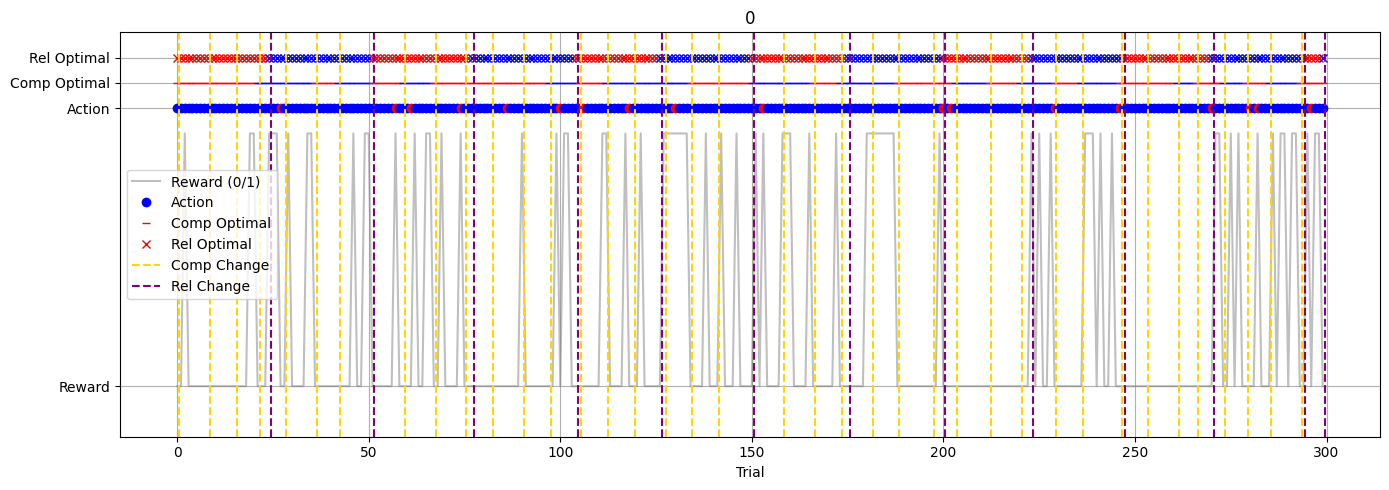

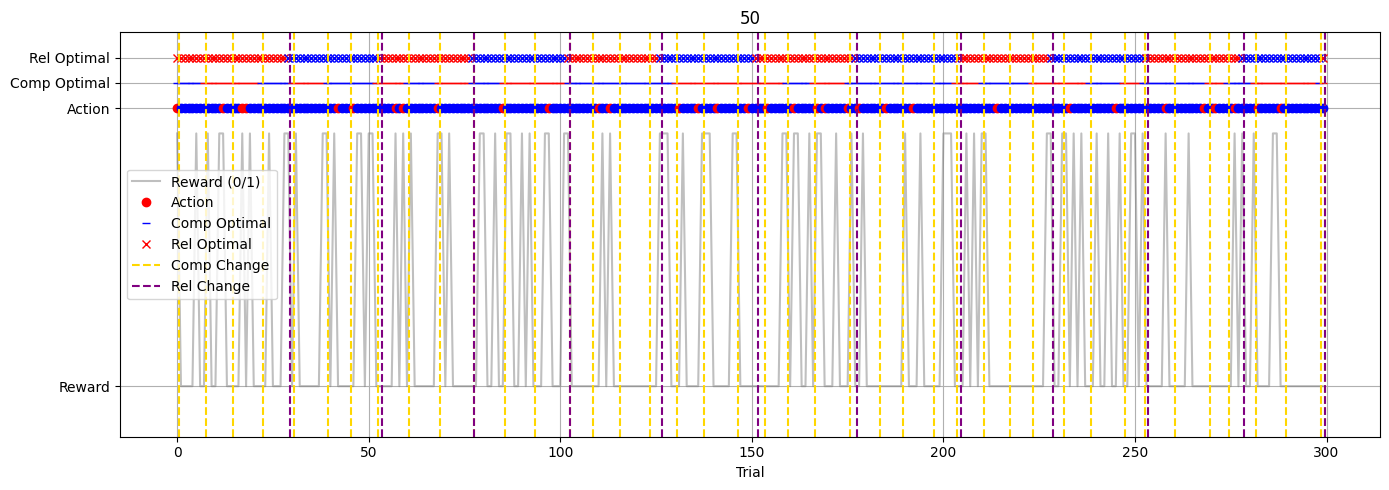

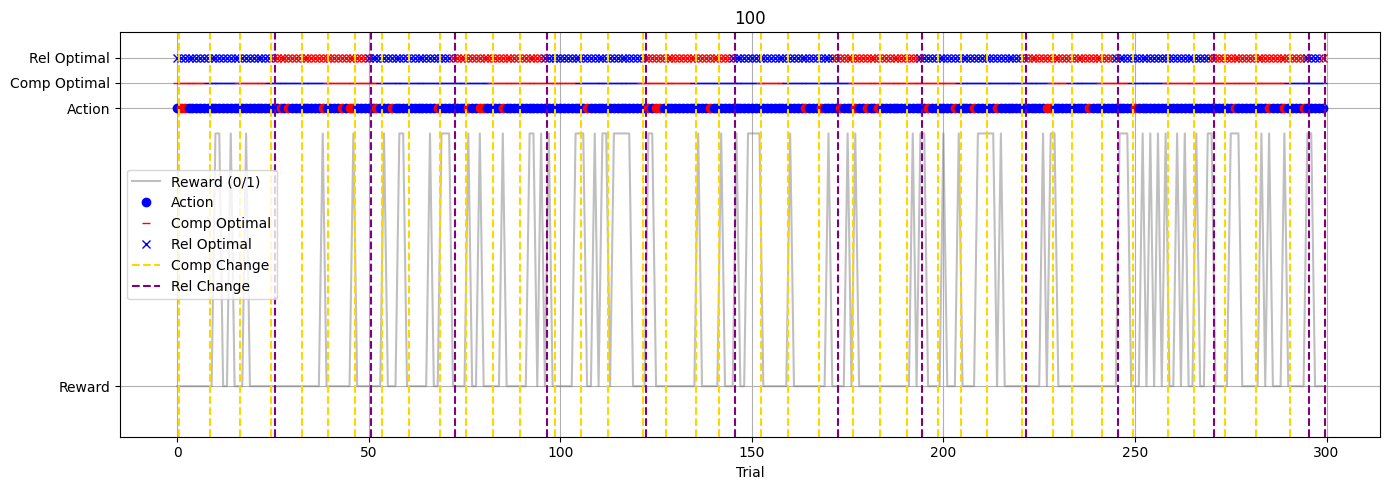

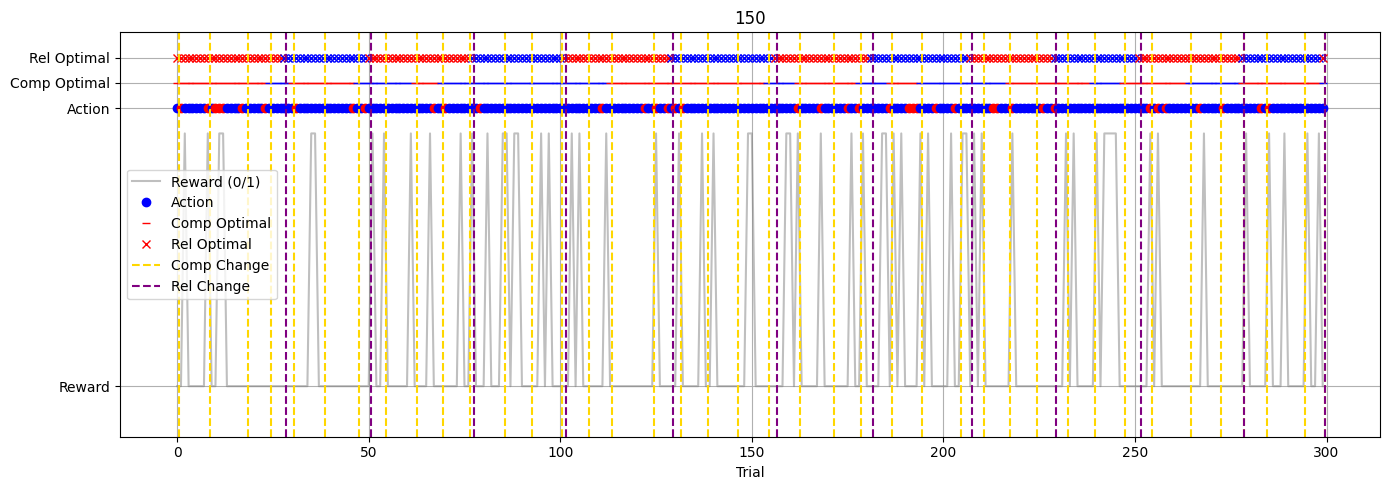

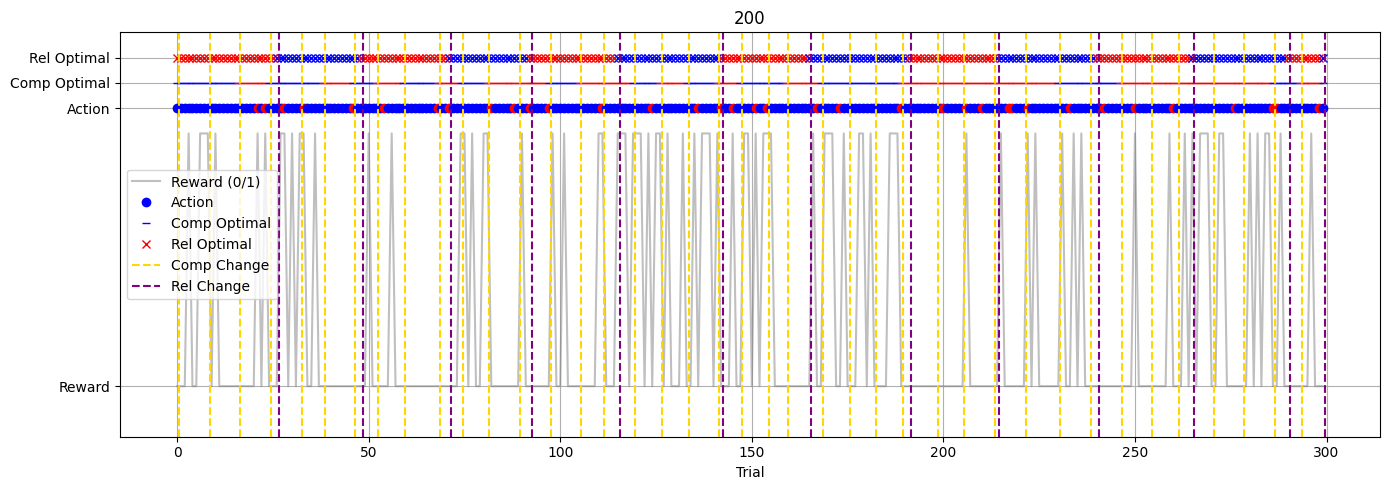

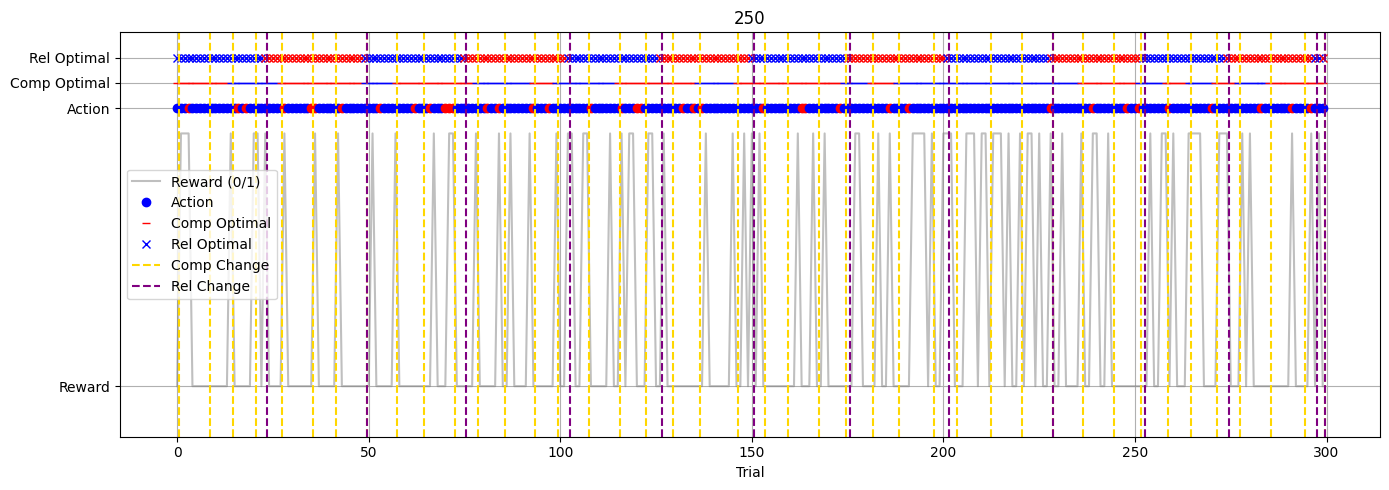

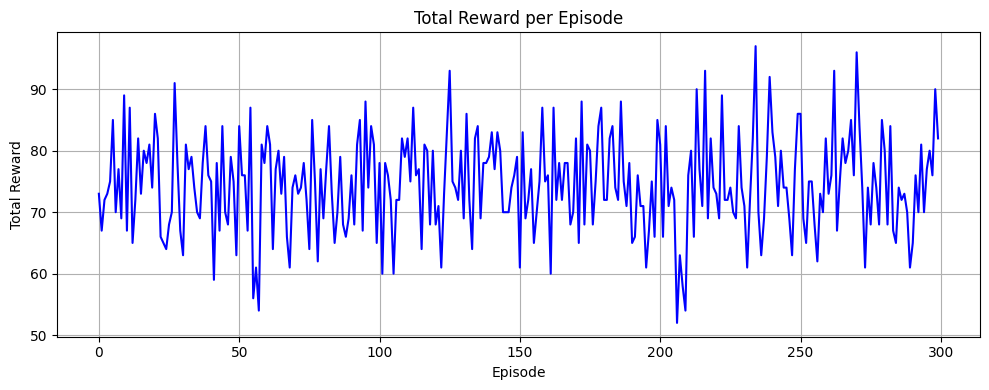

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Quantization

def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))

# 환경 클래스
class FullBayesianEelEnv:
    def __init__(self, trials):
        self.trials = trials
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.trial_log = []

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.trial_log = []
        return self.get_state()

    def compute_reliability_posteriors(self, window=7, high=0.25, low=0.10):
        recent = self.trial_log[-window:]
        lh_h1 = lh_h2 = 1.0
        for action, reward, _ in recent:
            rel_h1 = high if action == 0 else low
            rel_h2 = low if action == 0 else high
            lh_h1 *= rel_h1 if reward else (1 - rel_h1)
            lh_h2 *= rel_h2 if reward else (1 - rel_h2)
        total = lh_h1 + lh_h2
        return (lh_h1 / total, lh_h2 / total) if total > 0 else (0.5, 0.5)

    def compute_competency_posteriors(self, window=7, max_catch=3.0):
        recent = self.trial_log[-window:]
        lh_h1 = lh_h2 = 1.0
        for action, _, n_fish in recent:
            catch_h1 = max_catch if action == 0 else 1.0
            catch_h2 = 1.0 if action == 0 else max_catch
            lh_h1 *= (n_fish + 1) / (max_catch + 1) if catch_h1 > catch_h2 else (1 - n_fish / (max_catch + 1))
            lh_h2 *= (n_fish + 1) / (max_catch + 1) if catch_h2 > catch_h1 else (1 - n_fish / (max_catch + 1))
        total = lh_h1 + lh_h2
        return (lh_h1 / total, lh_h2 / total) if total > 0 else (0.5, 0.5)

    def compute_action_posteriors_by_side(self, window=7):
        recent = self.trial_log[-window:]
        if not recent:
            return (0.5, 0.5)

        lh_left_good = lh_left_bad = 1.0
        lh_right_good = lh_right_bad = 1.0

        for action, reward, _ in recent:
            if action == 0:
                lh_left_good *= 0.8 if reward else 0.2
                lh_left_bad *= 0.2 if reward else 0.8
            else:
                lh_right_good *= 0.8 if reward else 0.2
                lh_right_bad *= 0.2 if reward else 0.8

        total_left = lh_left_good + lh_left_bad
        total_right = lh_right_good + lh_right_bad

        post_left = lh_left_good / total_left if total_left > 0 else 0.5
        post_right = lh_right_good / total_right if total_right > 0 else 0.5

        return post_left, post_right

    def step(self, action):
        row = self.trials.iloc[self.current_trial]
        comp = row['left_competency'] if action == 0 else row['right_competency']
        rel = row['left_reliability'] if action == 0 else row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        self.trial_log.append((action, reward, n_fish))
        self.last_n_fish = n_fish
        self.current_trial += 1
        self.done = self.current_trial >= len(self.trials)
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        rel_l, rel_r = self.compute_reliability_posteriors()
        comp_l, comp_r = self.compute_competency_posteriors()
        act_left, act_right = self.compute_action_posteriors_by_side()
        return np.array([self.last_n_fish, rel_l, rel_r, comp_l, comp_r, act_left, act_right])

# 학습 설정
n_states = (4, 11, 11, 11, 11, 11, 11)
n_actions = 2
Q = np.zeros(n_states + (n_actions,))
epsilon, alpha, gamma = 0.1, 0.1, 0.9
n_episodes = 300
avg_rewards = []
episode_plots = {}

# 학습 루프
for ep in range(n_episodes):
    df, comp_changes, rel_changes = generate_trials()
    env = FullBayesianEelEnv(df)
    state = env.reset()
    s = tuple([state[0].astype(int)] + [quantize(x) for x in state[1:]])
    action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[s])
    done = False
    ep_reward = 0
    rewards = []
    actions = []
    optimal_comp = []
    optimal_rel = []

    while not done:
        row = env.trials.iloc[env.current_trial]
        left_comp, right_comp = row['left_competency'], row['right_competency']
        left_rel, right_rel = row['left_reliability'], row['right_reliability']
        actions.append(action)
        optimal_comp.append(0 if left_comp > right_comp else 1)
        optimal_rel.append(0 if left_rel > right_rel else 1)

        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)

        next_s = tuple([next_state[0].astype(int)] + [quantize(x) for x in next_state[1:]])
        next_action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[next_s])
        Q[s + (action,)] += alpha * (reward + gamma * Q[next_s + (next_action,)] - Q[s + (action,)])
        s = next_s
        action = next_action
        ep_reward += reward

    avg_rewards.append(ep_reward)
    if ep % 50 == 0:
        episode_plots[ep] = (df, comp_changes, rel_changes, actions, rewards)

# -------- Plot Results --------
for ep, (df, comp_changes, rel_changes, actions, rewards) in episode_plots.items():
    visualize_episode(df, comp_changes, rel_changes, actions, rewards, ep)

plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.grid(True)
plt.tight_layout()
plt.show()


### 🚧 [working on now] Bayesian Reliability refactoring



I've realized that every bayesian reliability function I was using may have some problems and are currently refactoring it
*   When computing reliability, the number of fish caught should be also taken into account, alongside with reward
*   Also, trials that I have chosen left or right should be only served as data for computing reliability for corresponding side.








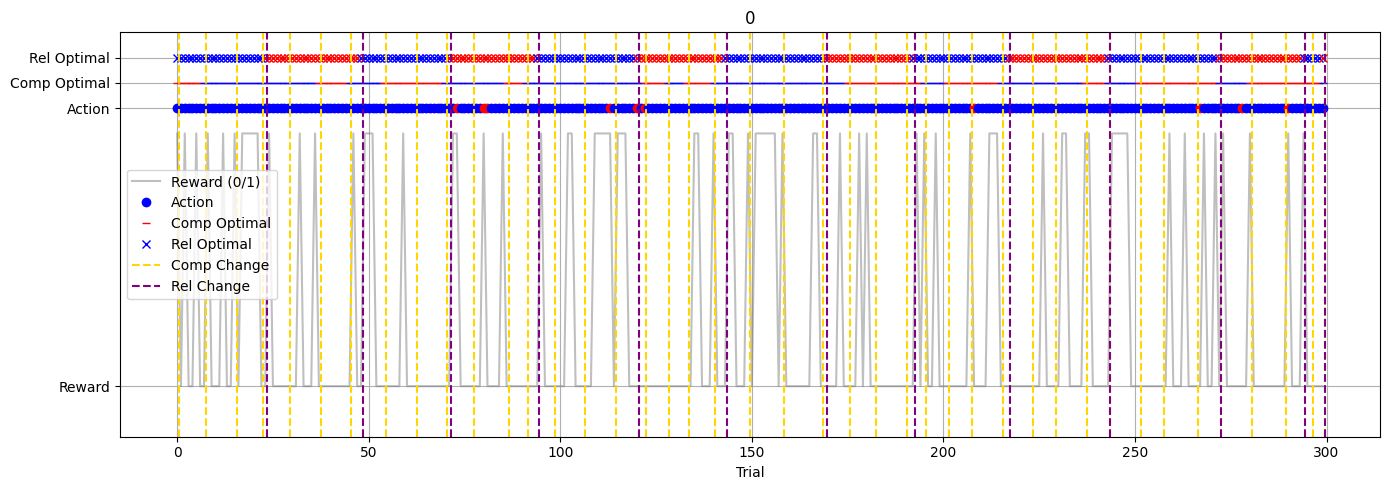

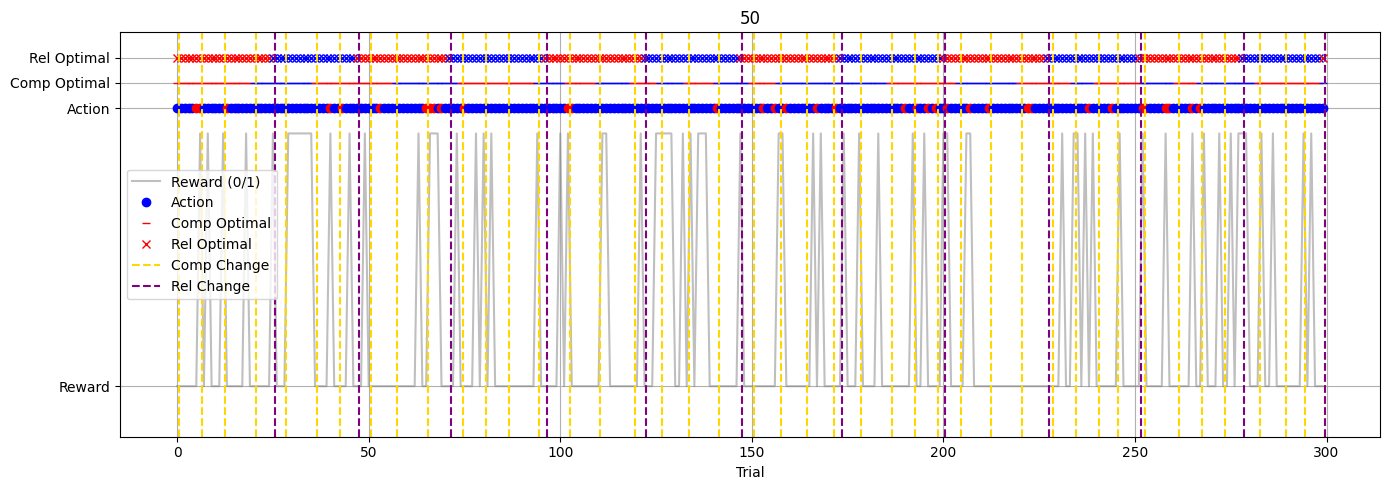

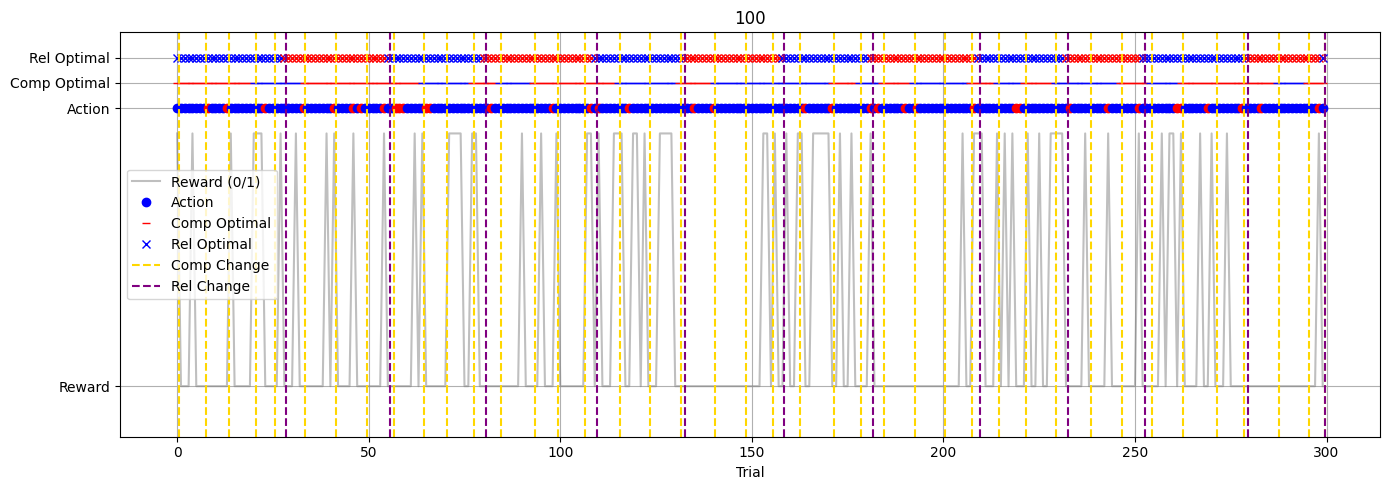

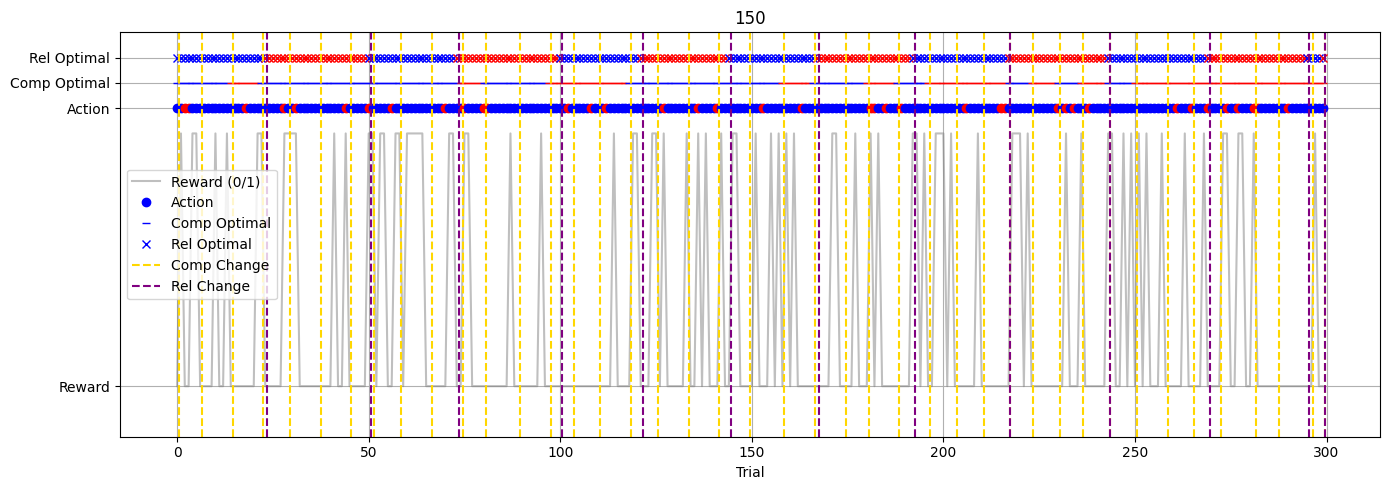

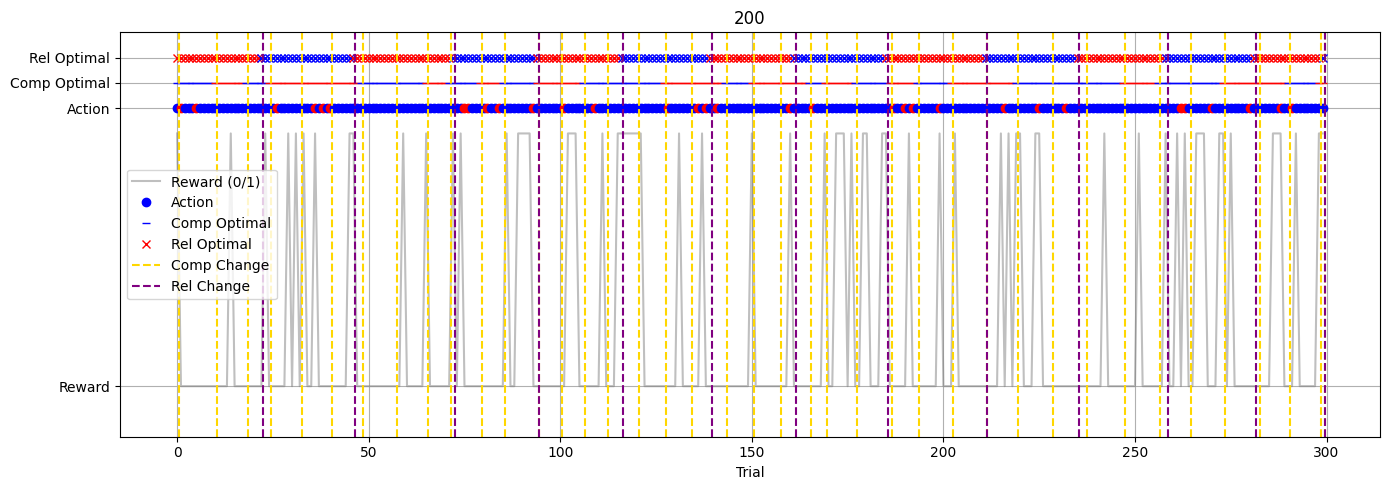

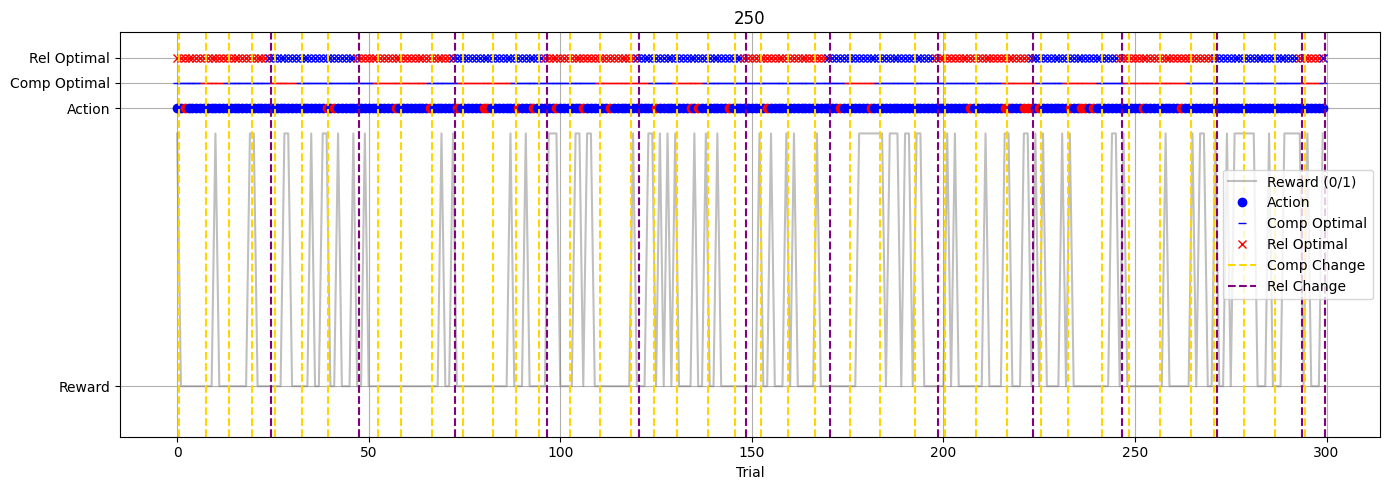

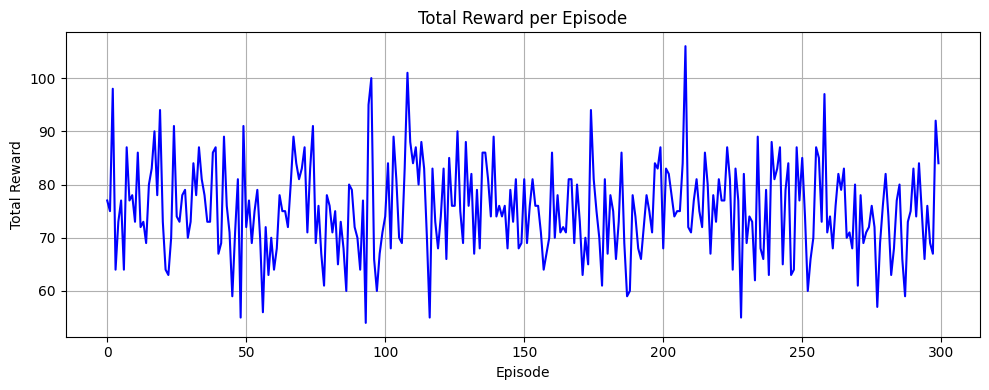

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Quantization

def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))

# 환경 클래스
class FullBayesianEelEnv:
    def __init__(self, trials):
        self.trials = trials
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.trial_log = []

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.trial_log = []
        return self.get_state()

    def compute_reliability_posteriors(self, window=7, high=0.25, low=0.10):
        recent = self.trial_log[-window:]
        left_lh = right_lh = 1.0
        for action, reward, n_fish in recent:
            # reward = Bernoulli(min(1.0, rel * n_fish)) 구조 고려
            if n_fish == 0:
                continue  # reward=0 고정이라 정보 없음
            if action == 0:  # 왼쪽 선택
                p_high = min(1.0, high * n_fish)
                p_low  = min(1.0, low * n_fish)
                left_lh *= p_high if reward else (1 - p_high)
                right_lh *= p_low if reward else (1 - p_low)
            else:  # 오른쪽 선택
                p_high = min(1.0, high * n_fish)
                p_low  = min(1.0, low * n_fish)
                right_lh *= p_high if reward else (1 - p_high)
                left_lh *= p_low if reward else (1 - p_low)
        total = left_lh + right_lh
        return (left_lh / total, right_lh / total) if total > 0 else (0.5, 0.5)

    def compute_competency_posteriors(self, window=7, max_catch=3.0):
        recent = self.trial_log[-window:]
        lh_h1 = lh_h2 = 1.0
        for action, _, n_fish in recent:
            catch_h1 = max_catch if action == 0 else 1.0
            catch_h2 = 1.0 if action == 0 else max_catch
            lh_h1 *= (n_fish + 1) / (max_catch + 1) if catch_h1 > catch_h2 else (1 - n_fish / (max_catch + 1))
            lh_h2 *= (n_fish + 1) / (max_catch + 1) if catch_h2 > catch_h1 else (1 - n_fish / (max_catch + 1))
        total = lh_h1 + lh_h2
        return (lh_h1 / total, lh_h2 / total) if total > 0 else (0.5, 0.5)

    def compute_action_posteriors_by_side(self, window=7):
        recent = self.trial_log[-window:]
        if not recent:
            return (0.5, 0.5)

        lh_left_good = lh_left_bad = 1.0
        lh_right_good = lh_right_bad = 1.0

        for action, reward, _ in recent:
            if action == 0:
                lh_left_good *= 0.8 if reward else 0.2
                lh_left_bad *= 0.2 if reward else 0.8
            else:
                lh_right_good *= 0.8 if reward else 0.2
                lh_right_bad *= 0.2 if reward else 0.8

        total_left = lh_left_good + lh_left_bad
        total_right = lh_right_good + lh_right_bad

        post_left = lh_left_good / total_left if total_left > 0 else 0.5
        post_right = lh_right_good / total_right if total_right > 0 else 0.5

        return post_left, post_right

    def step(self, action):
        row = self.trials.iloc[self.current_trial]
        comp = row['left_competency'] if action == 0 else row['right_competency']
        rel = row['left_reliability'] if action == 0 else row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        self.trial_log.append((action, reward, n_fish))
        self.last_n_fish = n_fish
        self.current_trial += 1
        self.done = self.current_trial >= len(self.trials)
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        rel_l, rel_r = self.compute_reliability_posteriors()
        comp_l, comp_r = self.compute_competency_posteriors()
        act_left, act_right = self.compute_action_posteriors_by_side()
        return np.array([self.last_n_fish, rel_l, rel_r, comp_l, comp_r, act_left, act_right])

# 학습 설정
n_states = (4, 11, 11, 11, 11, 11, 11)
n_actions = 2
Q = np.zeros(n_states + (n_actions,))
epsilon, alpha, gamma = 0.1, 0.1, 0.9
n_episodes = 300
avg_rewards = []
episode_plots = {}

# 학습 루프
for ep in range(n_episodes):
    df, comp_changes, rel_changes = generate_trials()
    env = FullBayesianEelEnv(df)
    state = env.reset()
    s = tuple([state[0].astype(int)] + [quantize(x) for x in state[1:]])
    action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[s])
    done = False
    ep_reward = 0
    rewards = []
    actions = []
    optimal_comp = []
    optimal_rel = []

    while not done:
        row = env.trials.iloc[env.current_trial]
        left_comp, right_comp = row['left_competency'], row['right_competency']
        left_rel, right_rel = row['left_reliability'], row['right_reliability']
        actions.append(action)
        optimal_comp.append(0 if left_comp > right_comp else 1)
        optimal_rel.append(0 if left_rel > right_rel else 1)

        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)

        next_s = tuple([next_state[0].astype(int)] + [quantize(x) for x in next_state[1:]])
        next_action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[next_s])
        Q[s + (action,)] += alpha * (reward + gamma * Q[next_s + (next_action,)] - Q[s + (action,)])
        s = next_s
        action = next_action
        ep_reward += reward

    avg_rewards.append(ep_reward)
    if ep % 50 == 0:
        episode_plots[ep] = (df, comp_changes, rel_changes, actions, rewards)

# -------- Plot Results --------
for ep, (df, comp_changes, rel_changes, actions, rewards) in episode_plots.items():
    visualize_episode(df, comp_changes, rel_changes, actions, rewards, ep)

plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.grid(True)
plt.tight_layout()
plt.show()


# [PAST WORKS] States without bayesian, but using recent values



*   BAYESIAN WAS NOT USED IN THIS SECTION, I ONLY USED RECENT TRIAL VALUES
*   some may surprisingly worked due to many episode iteration?
*   **It is before I refactored generate_trials function, so you will need to refactor these codes also with new generate_trials**




*   code may not be neat







### ⁉ state = [last_n_fish, left_posterior, right_posterior, last_action]

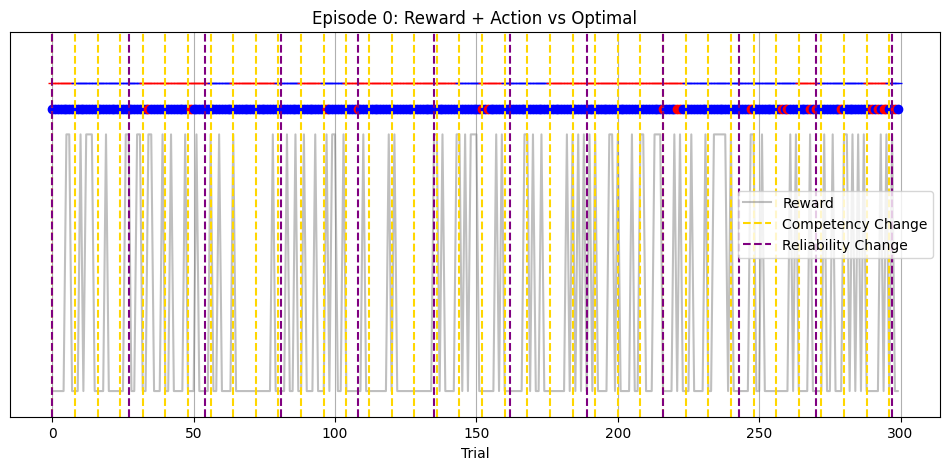

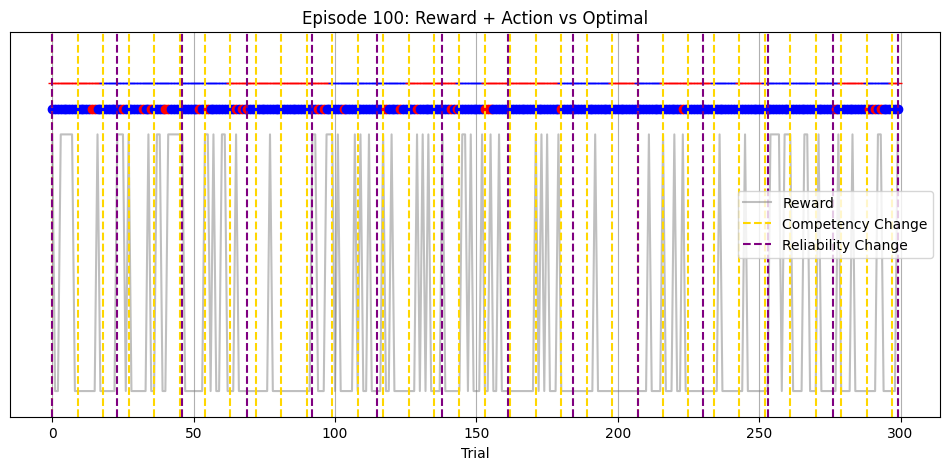

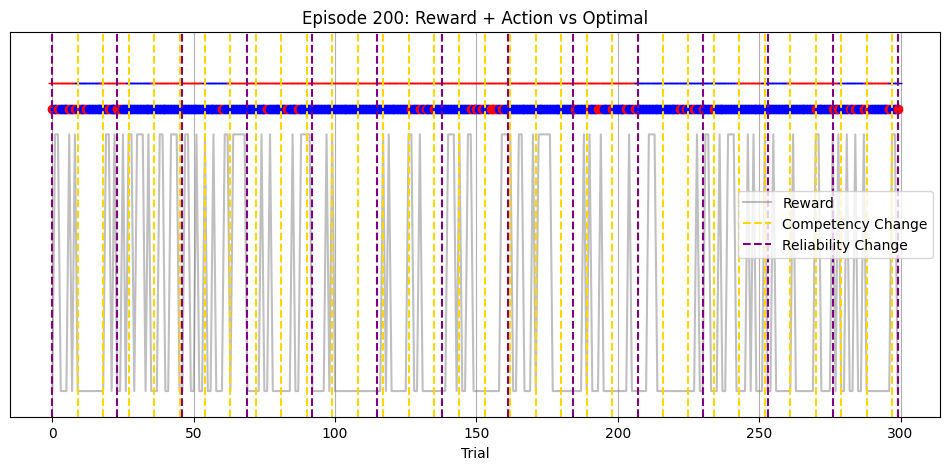

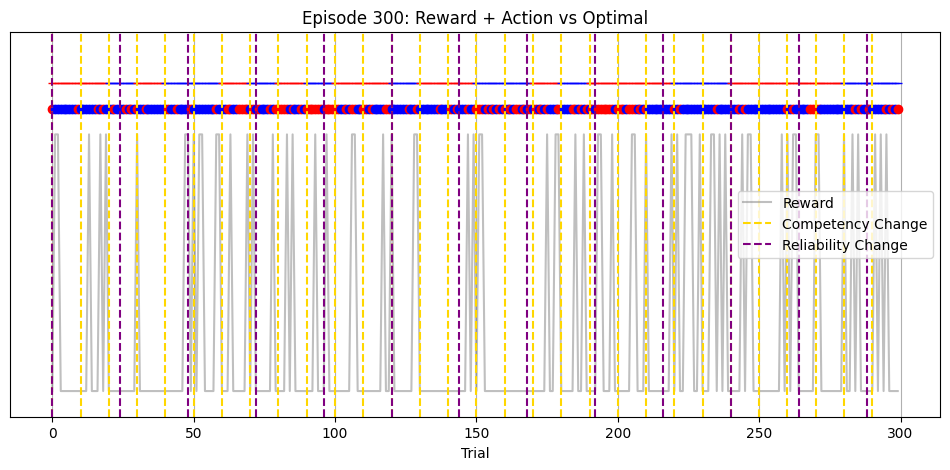

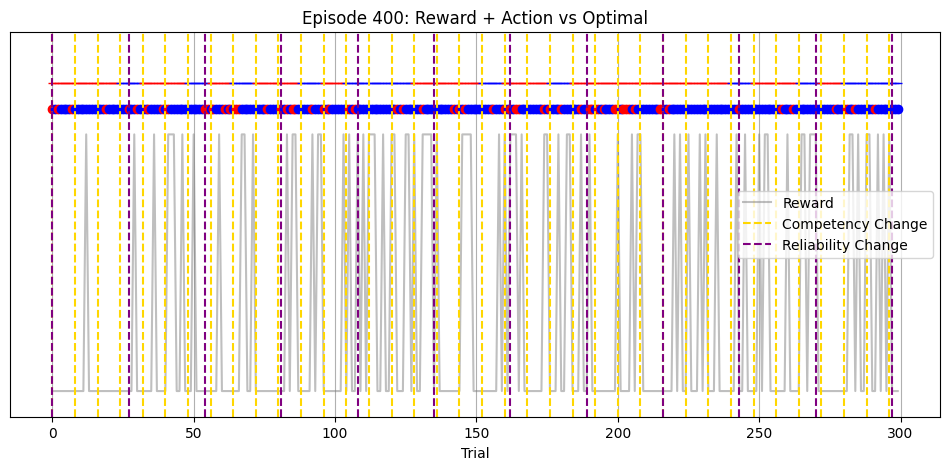

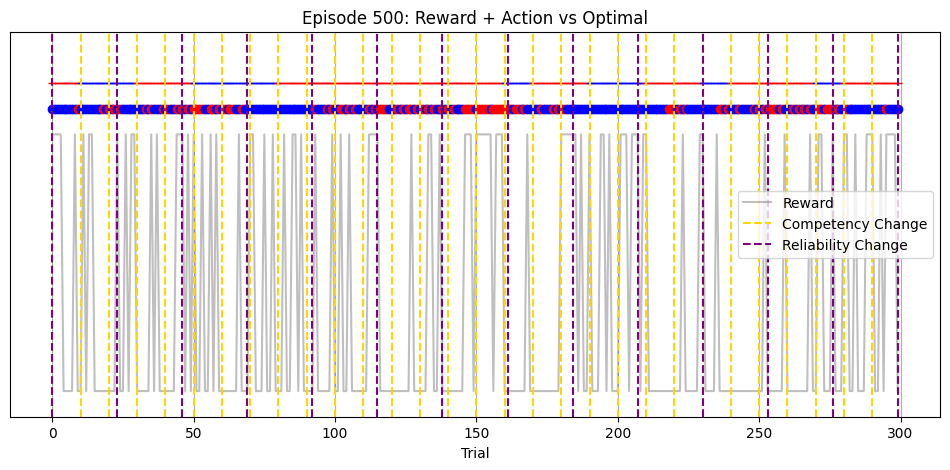

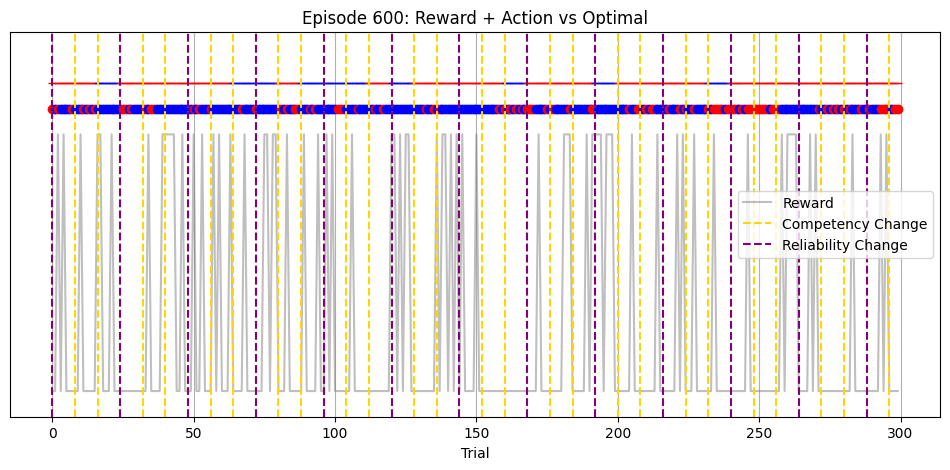

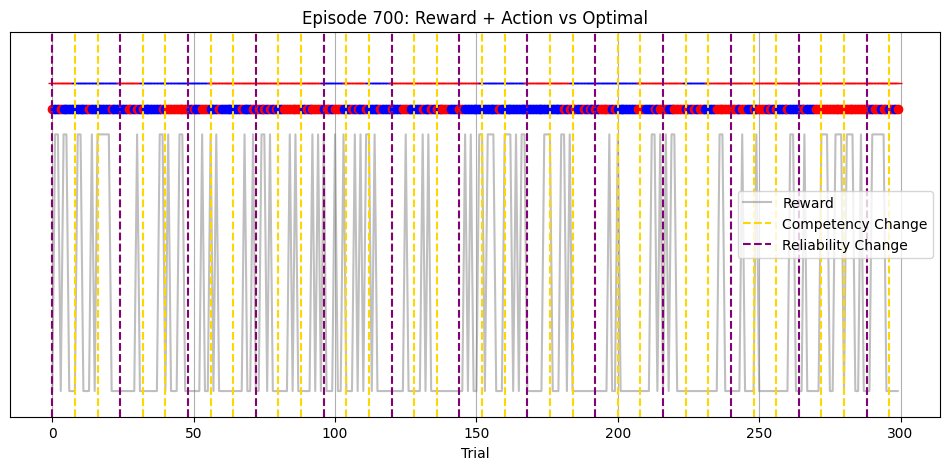

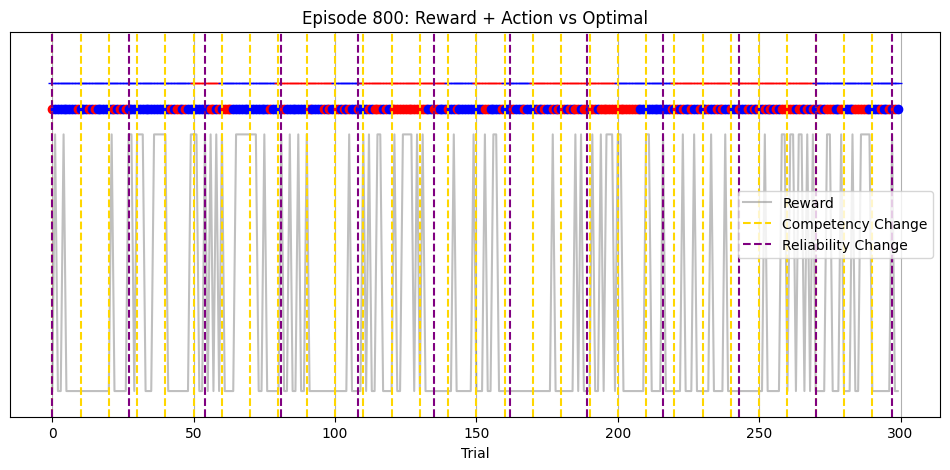

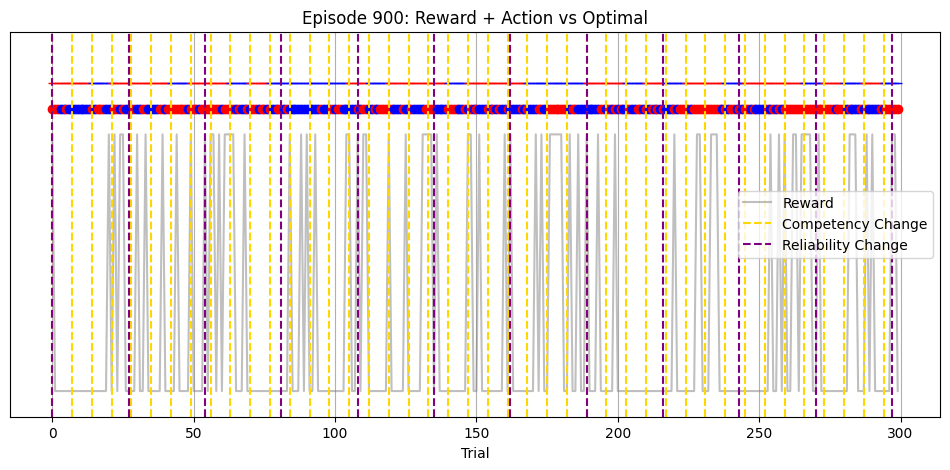

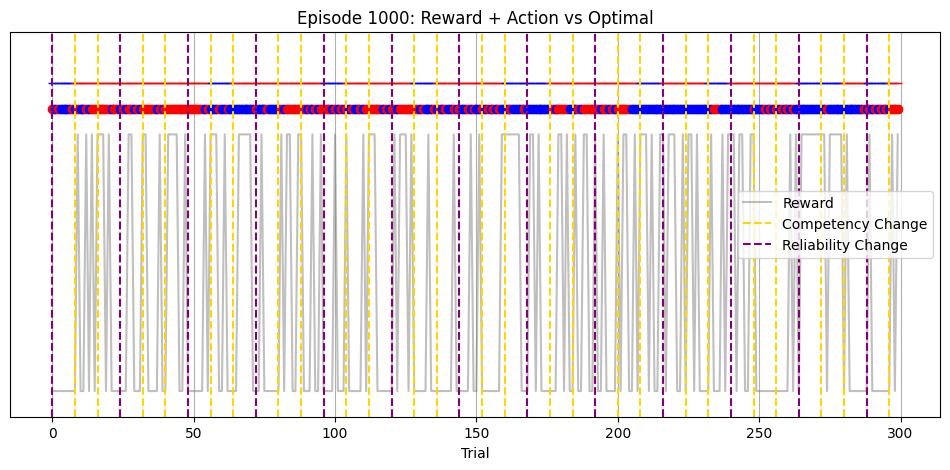

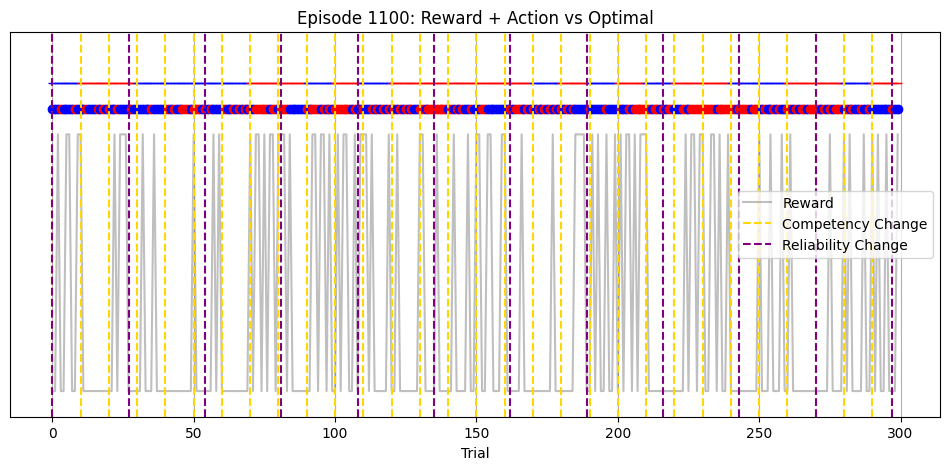

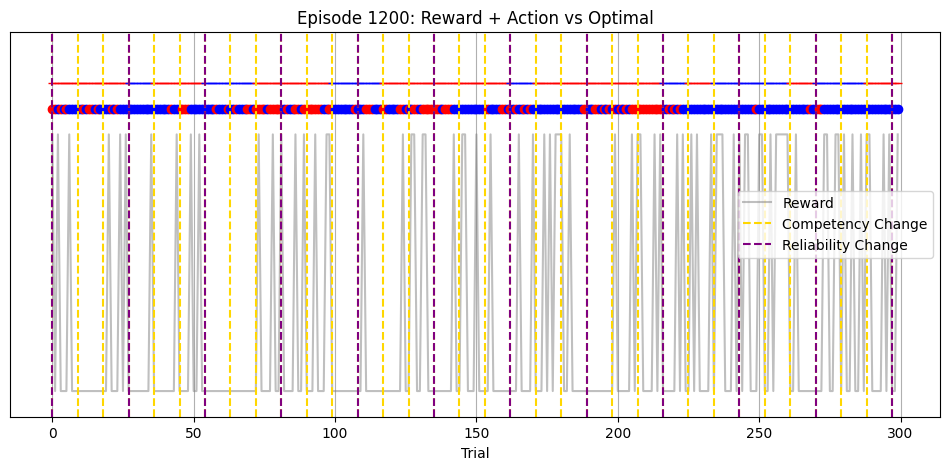

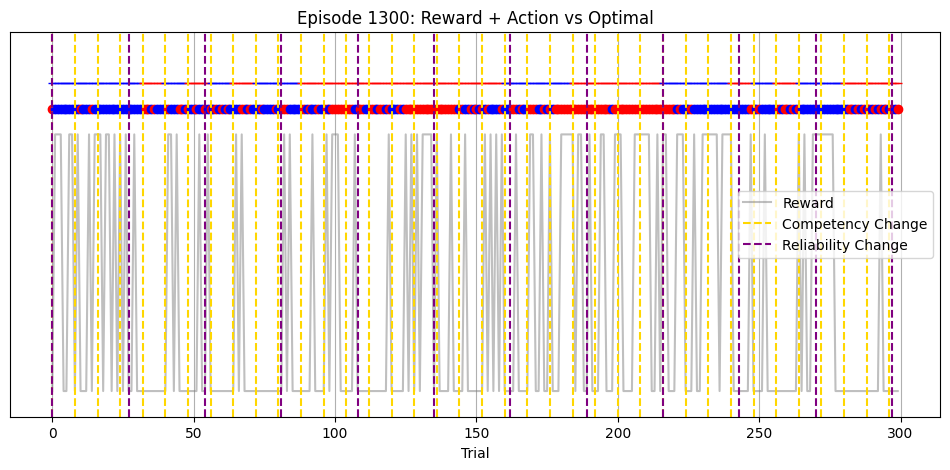

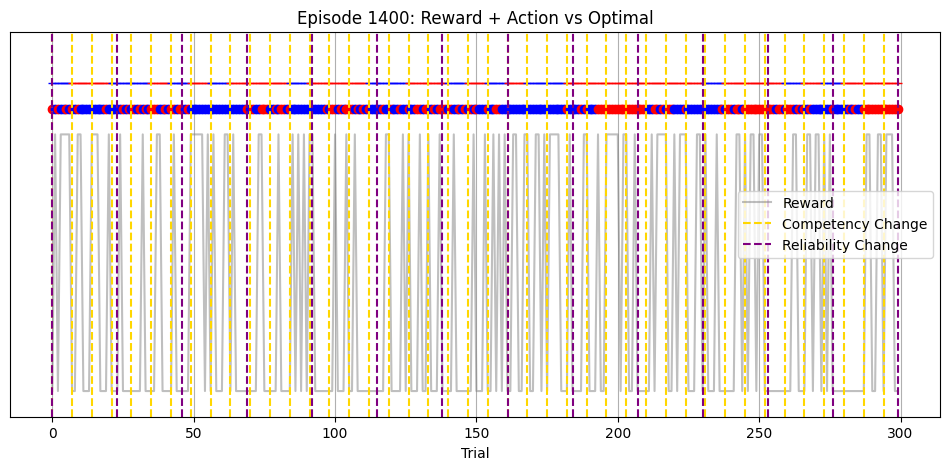

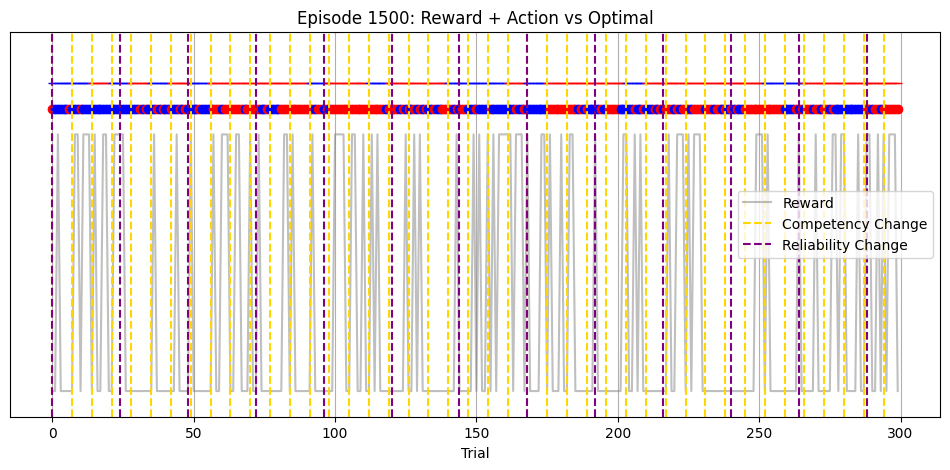

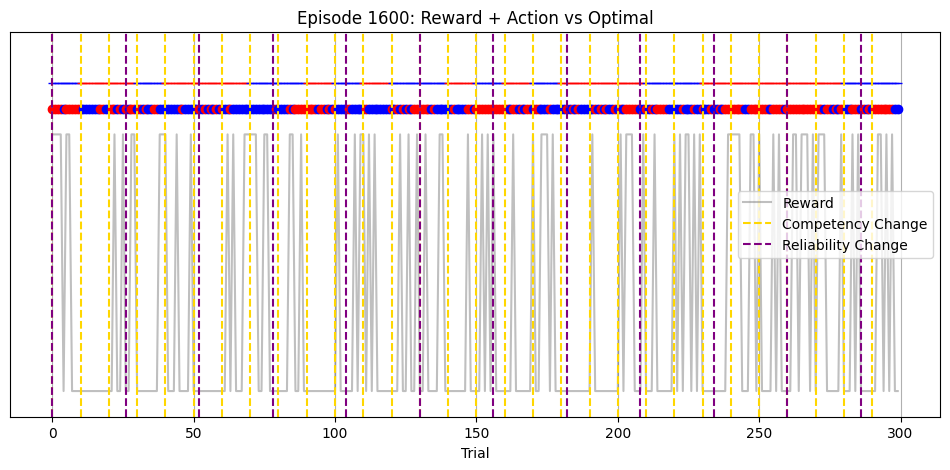

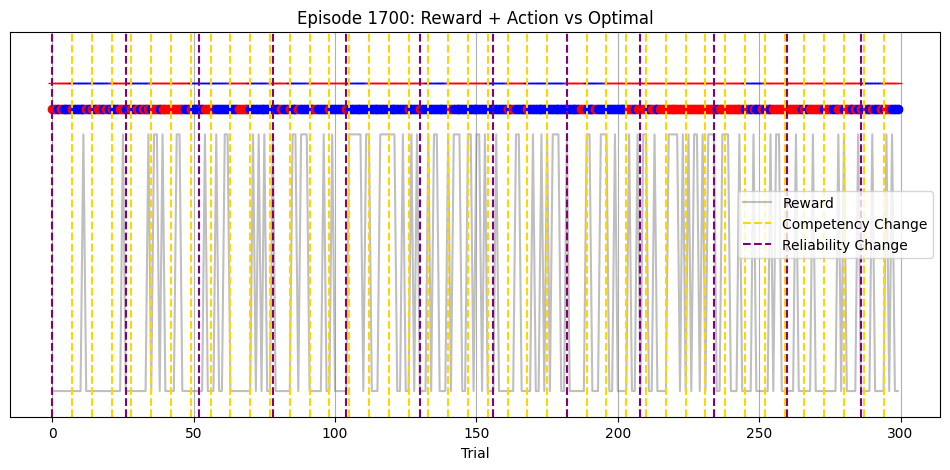

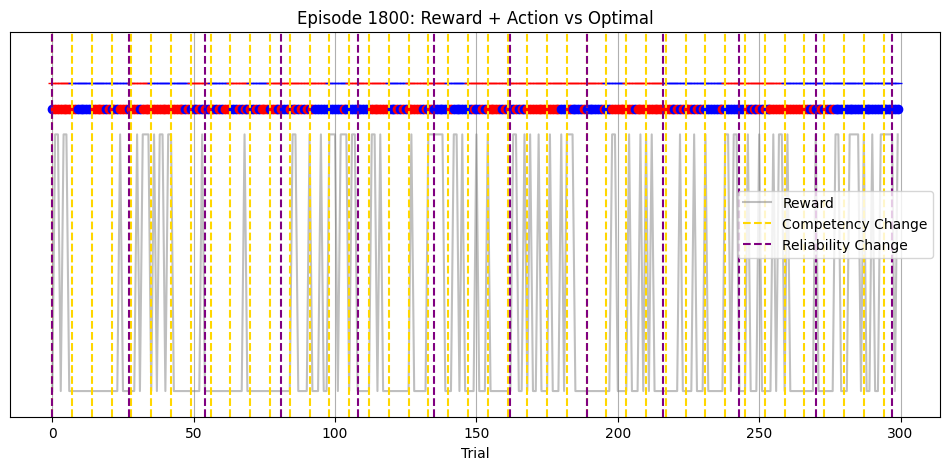

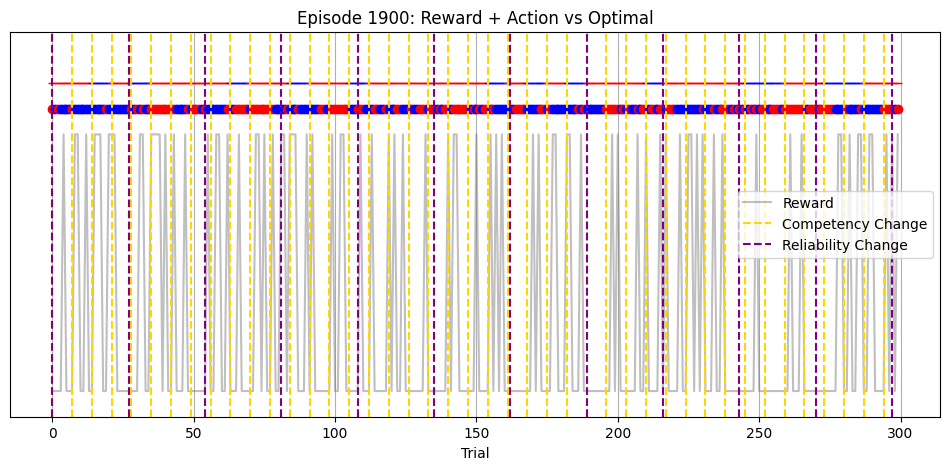

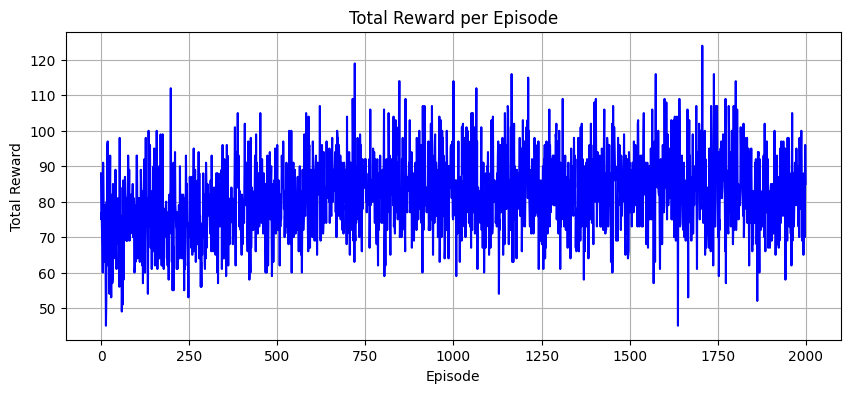

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Trial 생성 함수
def generate_trials(n_trials=300):
    comps = [0.4, 0.55, 0.7, 0.9]
    trials = []
    comp_block = np.random.choice([7, 8, 9, 10])
    rel_block = np.random.choice([23, 24, 25, 26, 27])
    left_comp = np.random.choice(comps)
    right_comp = np.random.choice(comps)
    left_rel = 0.25
    right_rel = 0.10
    comp_change_points = []
    rel_change_points = []
    for t in range(n_trials):
        if t % comp_block == 0:
            left_comp = np.random.choice(comps)
            right_comp = np.random.choice(comps)
            comp_change_points.append(t)
        if t % rel_block == 0:
            if np.random.rand() < 0.5:
                left_rel, right_rel = 0.25, 0.10
            else:
                left_rel, right_rel = 0.10, 0.25
            rel_change_points.append(t)
        trials.append({
            'left_competency': left_comp,
            'right_competency': right_comp,
            'left_reliability': left_rel,
            'right_reliability': right_rel
        })
    return pd.DataFrame(trials), comp_change_points, rel_change_points

# 환경 클래스
class EelEnv:
    def __init__(self, trial_data):
        self.trials = trial_data
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.left_rewards = []
        self.right_rewards = []

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.left_rewards = []
        self.right_rewards = []
        return self.get_state()

    def compute_posterior(self, rewards, high=0.25, low=0.10, memory_window=7):
        if not rewards:
            return 0.5
        recent = rewards[-memory_window:]
        lh_high = np.prod([high if r else 1 - high for r in recent])
        lh_low = np.prod([low if r else 1 - low for r in recent])
        return lh_high / (lh_high + lh_low) if (lh_high + lh_low) > 0 else 0.5

    def step(self, action):
        if self.done:
            return self.get_state(), 0, True, {}
        row = self.trials.iloc[self.current_trial]
        if action == 0:
            comp = row['left_competency']
            rel = row['left_reliability']
        else:
            comp = row['right_competency']
            rel = row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        if action == 0:
            self.left_rewards.append(reward)
        else:
            self.right_rewards.append(reward)
        self.last_n_fish = n_fish
        self.current_trial += 1
        if self.current_trial >= len(self.trials):
            self.done = True
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        left_p = self.compute_posterior(self.left_rewards)
        right_p = self.compute_posterior(self.right_rewards)
        return np.array([self.last_n_fish, left_p, right_p])

# quantize 함수 (확률값을 이산화)
def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))

# Q-learning 파라미터
n_states = (4, 11, 11, 2)  # n_fish, left_p, right_p, last_action
n_actions = 2
Q = np.zeros(n_states + (n_actions,))
epsilon = 0.1
alpha = 0.1
gamma = 0.9
n_episodes = 2000
avg_rewards = []
episode_plots = {}

# 학습 루프
for ep in range(n_episodes):
    df, comp_changes, rel_changes = generate_trials()
    env = EelEnv(df)
    state = env.reset()
    n_fish, left_p, right_p = state[0].astype(int), quantize(state[1]), quantize(state[2])
    last_action = 0
    q_state = (n_fish, left_p, right_p, last_action)
    action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[q_state])
    done = False
    ep_reward = 0
    reward_trajectory = []
    actions_taken = []
    optimal_side = []

    while not done:
        row = env.trials.iloc[env.current_trial]
        left_comp = row['left_competency']
        right_comp = row['right_competency']
        optimal = 0 if left_comp > right_comp else 1
        optimal_side.append(optimal)
        actions_taken.append(action)

        next_state, reward, done, _ = env.step(action)
        next_n_fish = next_state[0].astype(int)
        next_q_state = (next_n_fish, quantize(next_state[1]), quantize(next_state[2]), action)
        next_action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[next_q_state])

        Q[q_state + (action,)] += alpha * (
            reward + gamma * Q[next_q_state + (next_action,)] - Q[q_state + (action,)]
        )

        q_state = next_q_state
        last_action = action
        action = next_action
        ep_reward += reward
        reward_trajectory.append(reward)

    avg_rewards.append(ep_reward)
    if ep % 100 == 0:
        episode_plots[ep] = (reward_trajectory, comp_changes, rel_changes, actions_taken, optimal_side)

# 시각화
for ep, (rewards, comp_changes, rel_changes, actions, optimal) in episode_plots.items():
    plt.figure(figsize=(12, 5))
    plt.plot(rewards, label='Reward', color='gray', alpha=0.5)
    for t in range(len(actions)):
        plt.plot(t, 1.1, 'bo' if actions[t] == 0 else 'ro')
        plt.plot(t, 1.2, 'b_' if optimal[t] == 0 else 'r_')
    for x in comp_changes:
        plt.axvline(x=x, color='gold', linestyle='--', label='Competency Change' if x == comp_changes[0] else "")
    for x in rel_changes:
        plt.axvline(x=x, color='purple', linestyle='--', label='Reliability Change' if x == rel_changes[0] else "")
    plt.title(f"Episode {ep}: Reward + Action vs Optimal")
    plt.xlabel("Trial")
    plt.ylim(-0.1, 1.4)
    plt.yticks([])
    plt.legend()
    plt.grid(True)
    plt.show()

# 전체 reward 그래프
plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.grid(True)
plt.show()


### ⁉ state = [last_n_fish, left_posterior, right_posterior, last_action, recent reward average(5)]

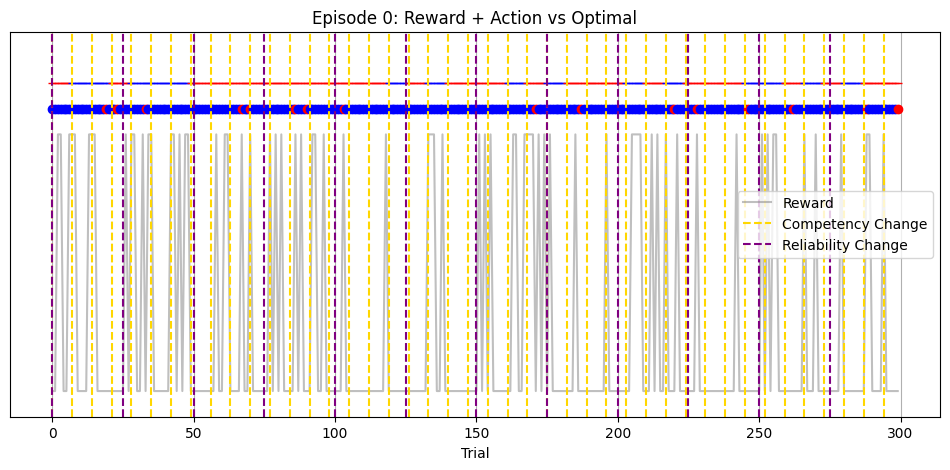

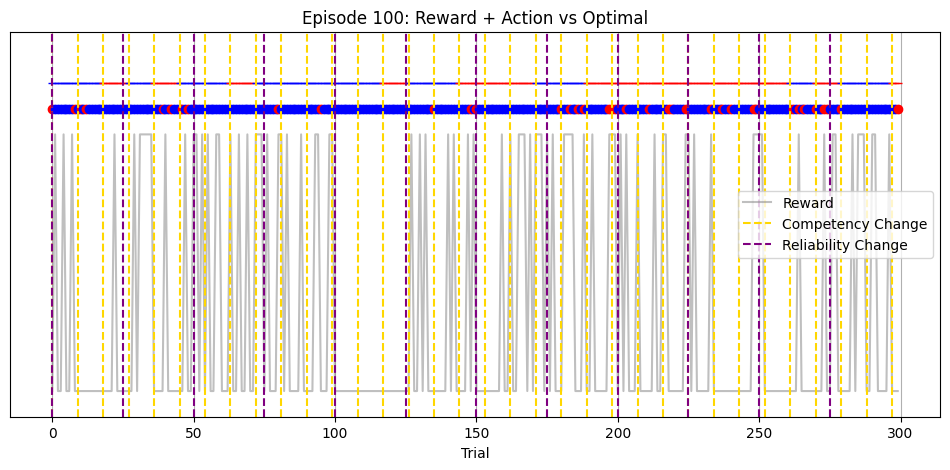

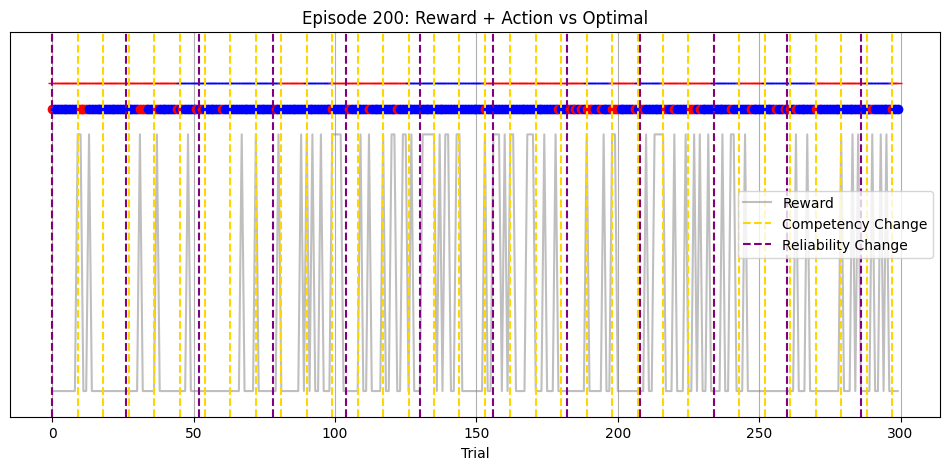

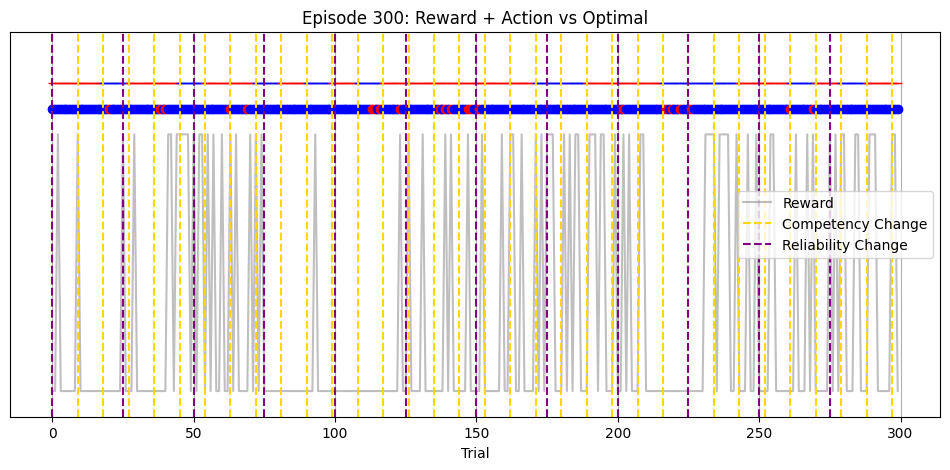

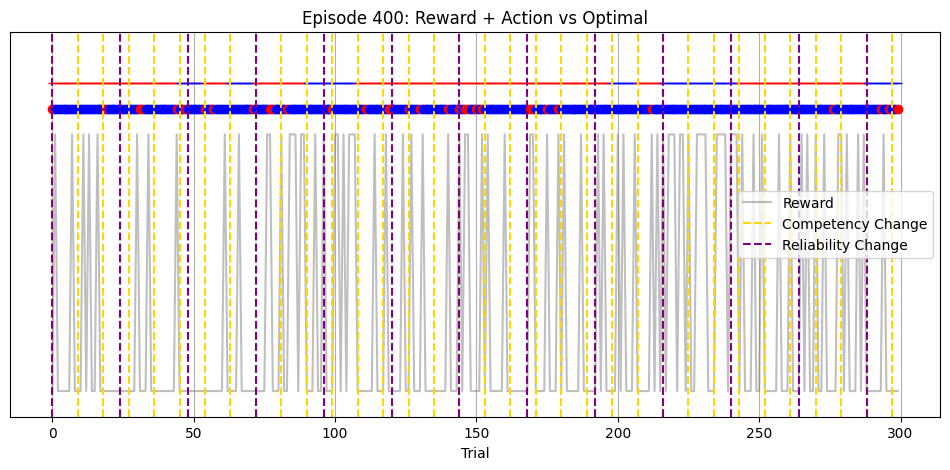

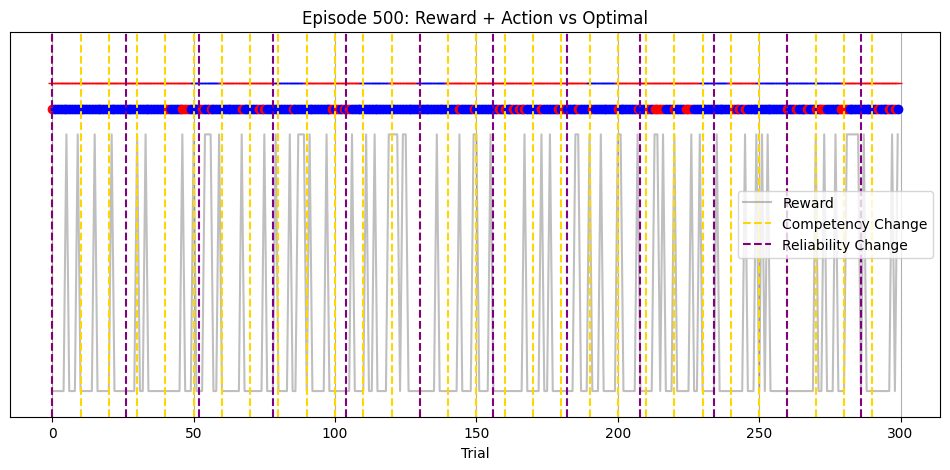

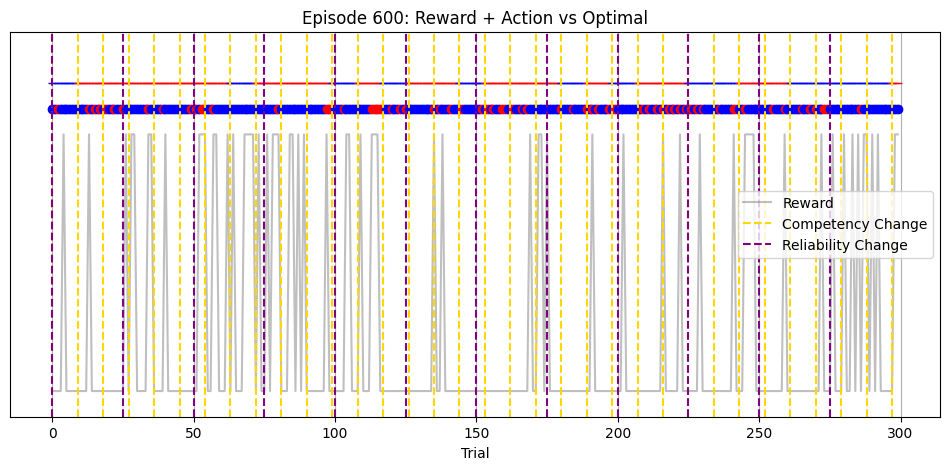

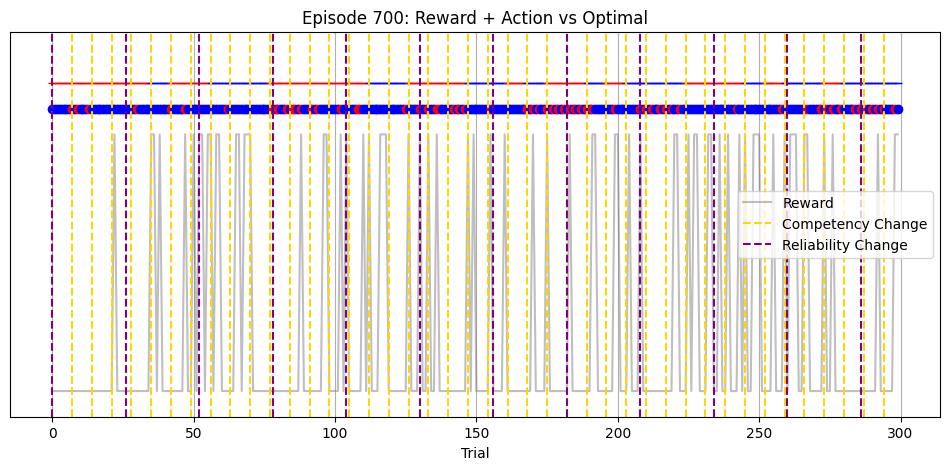

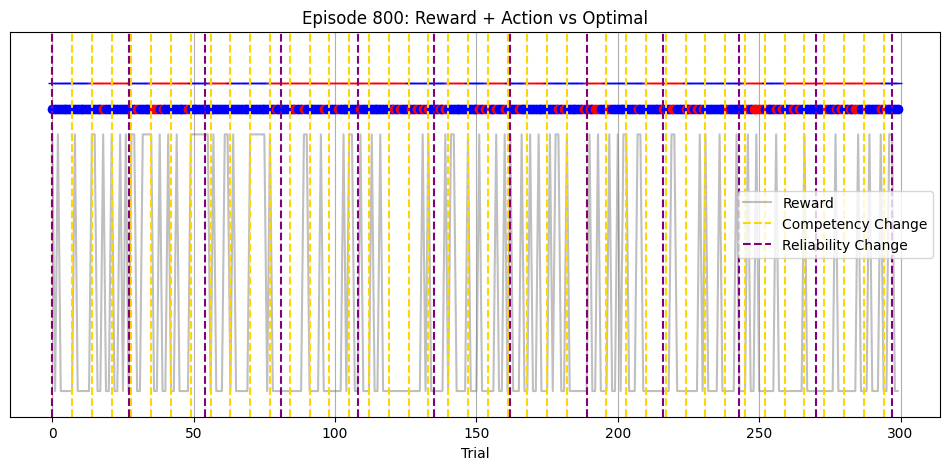

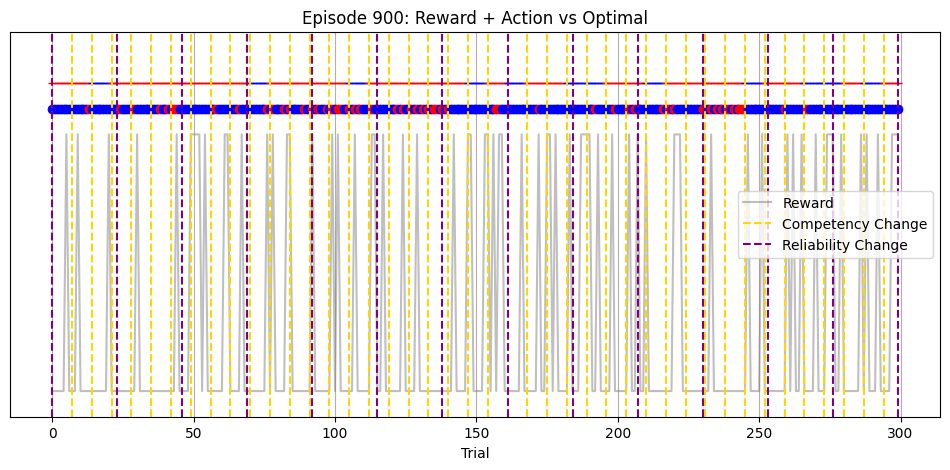

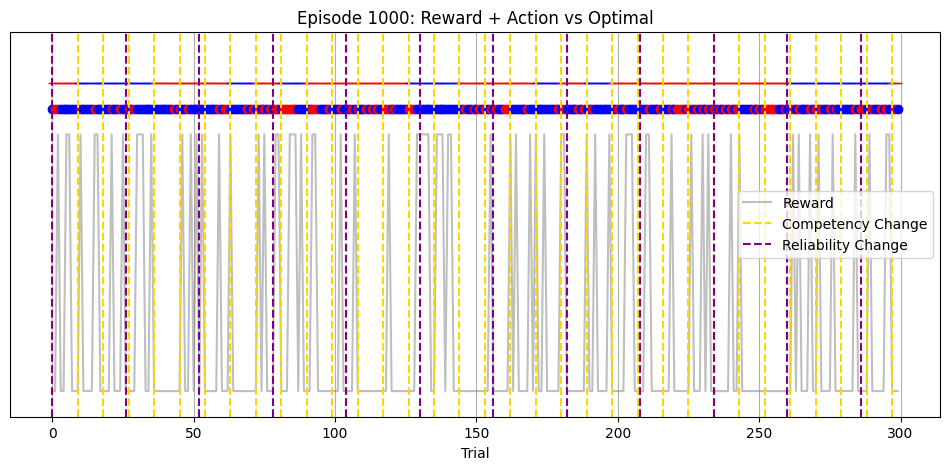

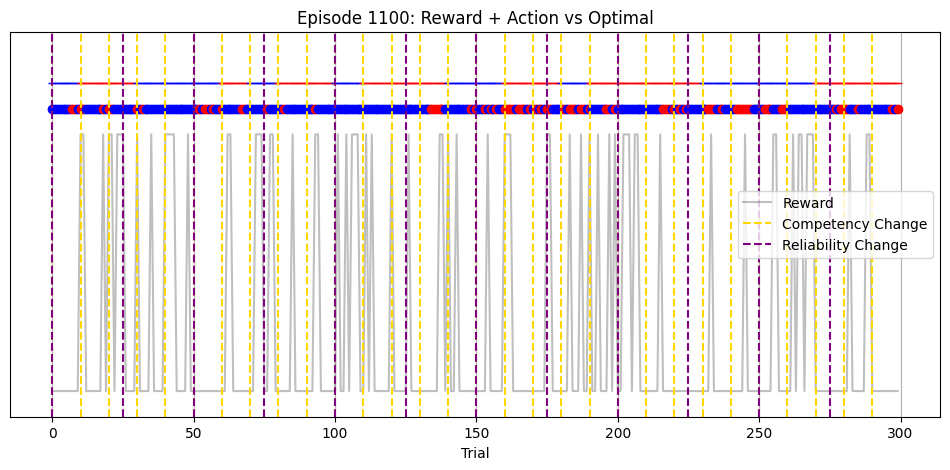

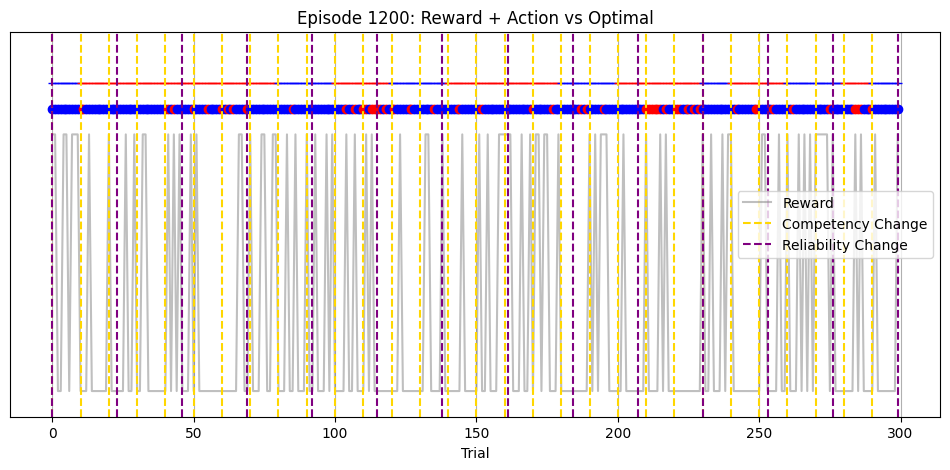

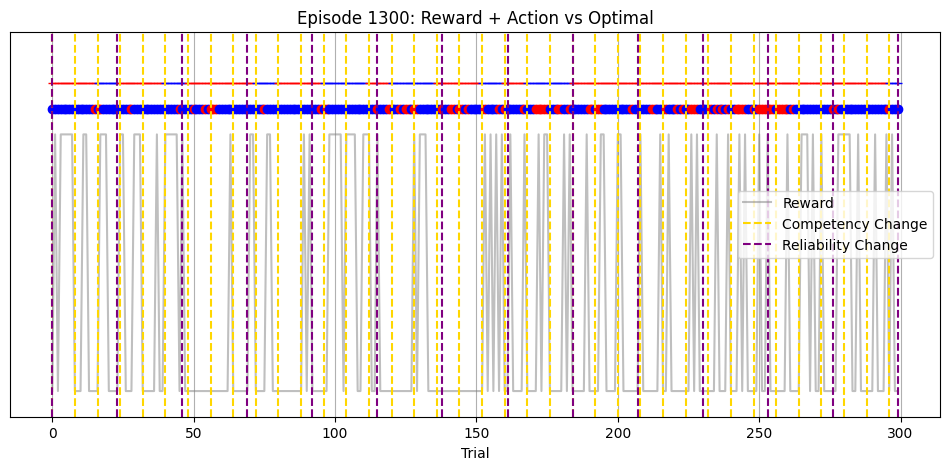

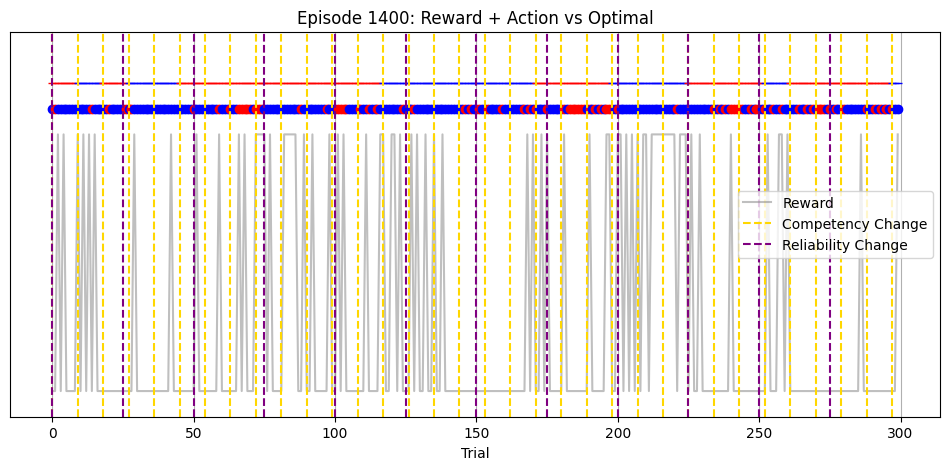

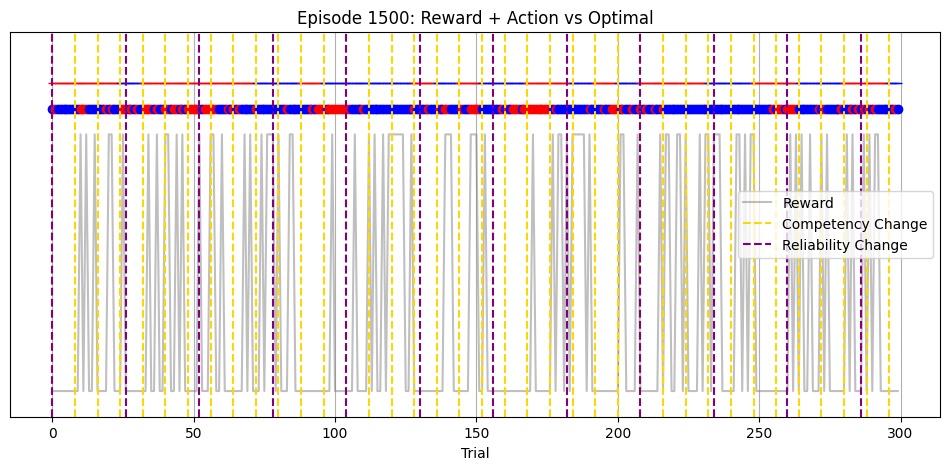

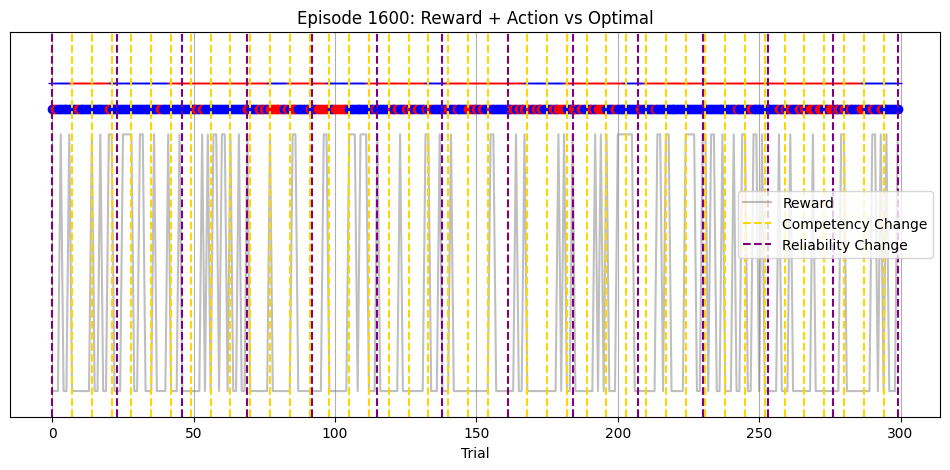

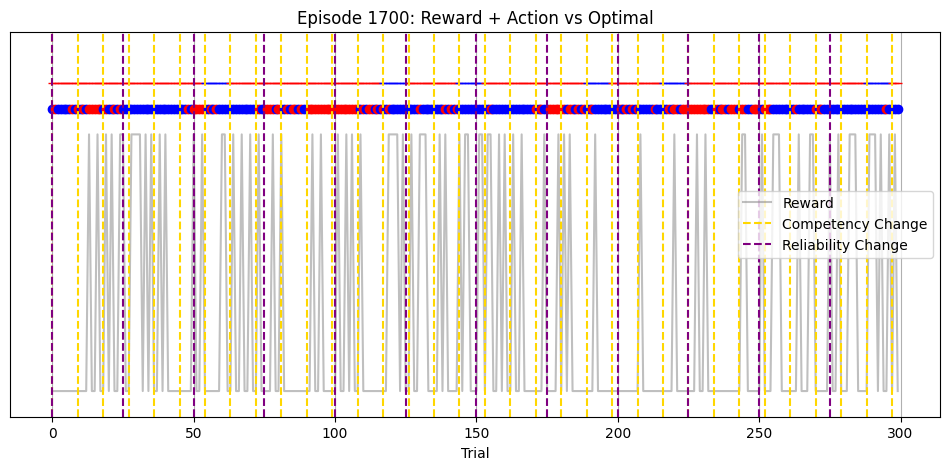

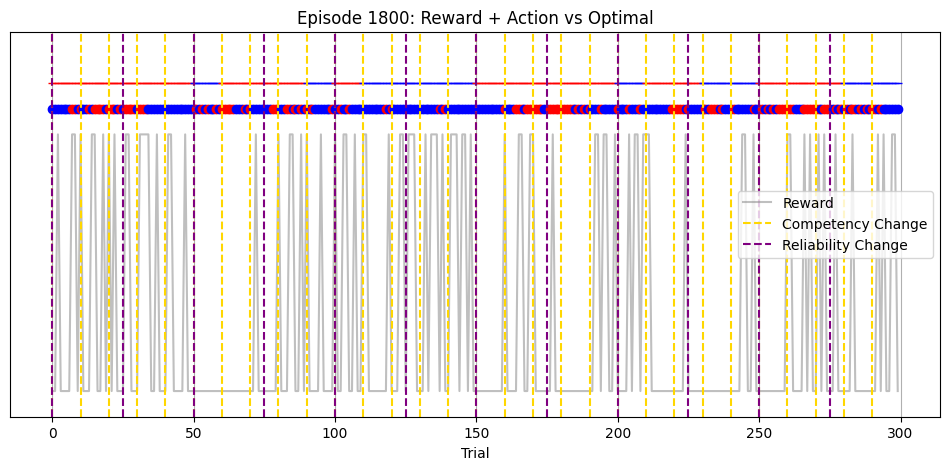

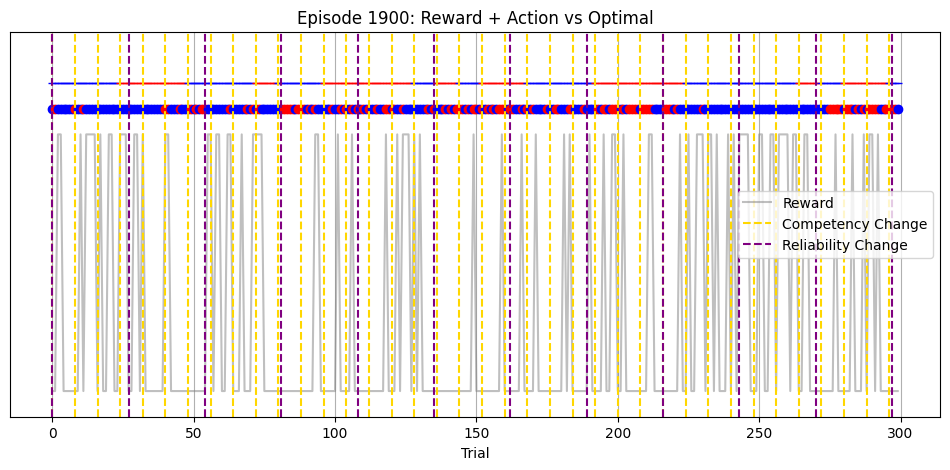

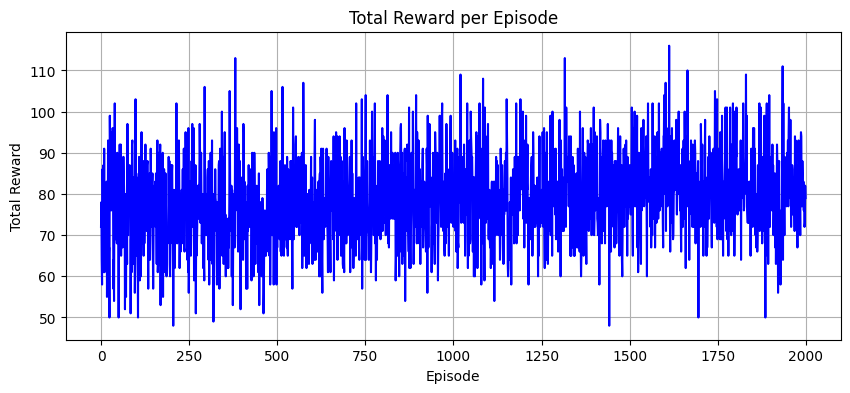

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Trial 생성 함수
def generate_trials(n_trials=300):
    comps = [0.4, 0.55, 0.7, 0.9]
    trials = []
    comp_block = np.random.choice([7, 8, 9, 10])
    rel_block = np.random.choice([23, 24, 25, 26, 27])
    left_comp = np.random.choice(comps)
    right_comp = np.random.choice(comps)
    left_rel = 0.25
    right_rel = 0.10
    comp_change_points = []
    rel_change_points = []
    for t in range(n_trials):
        if t % comp_block == 0:
            left_comp = np.random.choice(comps)
            right_comp = np.random.choice(comps)
            comp_change_points.append(t)
        if t % rel_block == 0:
            if np.random.rand() < 0.5:
                left_rel, right_rel = 0.25, 0.10
            else:
                left_rel, right_rel = 0.10, 0.25
            rel_change_points.append(t)
        trials.append({
            'left_competency': left_comp,
            'right_competency': right_comp,
            'left_reliability': left_rel,
            'right_reliability': right_rel
        })
    return pd.DataFrame(trials), comp_change_points, rel_change_points

# 환경 클래스
class EelEnv:
    def __init__(self, trial_data):
        self.trials = trial_data
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.left_rewards = []
        self.right_rewards = []

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.left_rewards = []
        self.right_rewards = []
        return self.get_state()

    def compute_posterior(self, rewards, high=0.25, low=0.10, memory_window=7):
        if not rewards:
            return 0.5
        recent = rewards[-memory_window:]
        lh_high = np.prod([high if r else 1 - high for r in recent])
        lh_low = np.prod([low if r else 1 - low for r in recent])
        return lh_high / (lh_high + lh_low) if (lh_high + lh_low) > 0 else 0.5

    def step(self, action):
        if self.done:
            return self.get_state(), 0, True, {}
        row = self.trials.iloc[self.current_trial]
        if action == 0:
            comp = row['left_competency']
            rel = row['left_reliability']
        else:
            comp = row['right_competency']
            rel = row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        if action == 0:
            self.left_rewards.append(reward)
        else:
            self.right_rewards.append(reward)
        self.last_n_fish = n_fish
        self.current_trial += 1
        if self.current_trial >= len(self.trials):
            self.done = True
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        left_p = self.compute_posterior(self.left_rewards)
        right_p = self.compute_posterior(self.right_rewards)
        return np.array([self.last_n_fish, left_p, right_p])

# quantize 함수 (확률값을 이산화)
def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))

# Q-learning 파라미터
n_states = (4, 11, 11, 2, 11)  # last_n_fish, left_p, right_p, last_action, recent_avg
n_actions = 2
Q = np.zeros(n_states + (n_actions,))
epsilon = 0.1
alpha = 0.1
gamma = 0.9
n_episodes = 2000
avg_rewards = []
episode_plots = {}

# 학습 루프
for ep in range(n_episodes):
    df, comp_changes, rel_changes = generate_trials()
    env = EelEnv(df)
    state = env.reset()
    n_fish, left_p, right_p = state[0].astype(int), quantize(state[1]), quantize(state[2])
    last_action = 0
    reward_window = []
    reward_avg = 0.5  # 초기 평균값
    q_state = (n_fish, left_p, right_p, last_action, quantize(reward_avg))
    action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[q_state])
    done = False
    ep_reward = 0
    reward_trajectory = []
    actions_taken = []
    optimal_side = []

    while not done:
        row = env.trials.iloc[env.current_trial]
        left_comp = row['left_competency']
        right_comp = row['right_competency']
        optimal = 0 if left_comp > right_comp else 1
        optimal_side.append(optimal)
        actions_taken.append(action)

        next_state, reward, done, _ = env.step(action)
        reward_window.append(reward)
        if len(reward_window) > 5:
            reward_window.pop(0)
        reward_avg = np.mean(reward_window)

        next_n_fish = next_state[0].astype(int)
        next_q_state = (
            next_n_fish,
            quantize(next_state[1]),
            quantize(next_state[2]),
            action,
            quantize(reward_avg)
        )
        next_action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[next_q_state])

        Q[q_state + (action,)] += alpha * (
            reward + gamma * Q[next_q_state + (next_action,)] - Q[q_state + (action,)]
        )

        q_state = next_q_state
        last_action = action
        action = next_action
        ep_reward += reward
        reward_trajectory.append(reward)

    avg_rewards.append(ep_reward)
    if ep % 100 == 0:
        episode_plots[ep] = (reward_trajectory, comp_changes, rel_changes, actions_taken, optimal_side)

# 시각화
for ep, (rewards, comp_changes, rel_changes, actions, optimal) in episode_plots.items():
    plt.figure(figsize=(12, 5))
    plt.plot(rewards, label='Reward', color='gray', alpha=0.5)
    for t in range(len(actions)):
        plt.plot(t, 1.1, 'bo' if actions[t] == 0 else 'ro')
        plt.plot(t, 1.2, 'b_' if optimal[t] == 0 else 'r_')
    for x in comp_changes:
        plt.axvline(x=x, color='gold', linestyle='--', label='Competency Change' if x == comp_changes[0] else "")
    for x in rel_changes:
        plt.axvline(x=x, color='purple', linestyle='--', label='Reliability Change' if x == rel_changes[0] else "")
    plt.title(f"Episode {ep}: Reward + Action vs Optimal")
    plt.xlabel("Trial")
    plt.ylim(-0.1, 1.4)
    plt.yticks([])
    plt.legend()
    plt.grid(True)
    plt.show()

# 전체 reward 그래프
plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.grid(True)
plt.show()


# Future Plans (will work on)

### Joint Bayesian

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- Quantization --------
def quantize(p):
    return int(np.clip(round(p * 10), 0, 10))

# -------- Gaussian Likelihood --------
def gaussian_likelihood(x, mu, std):
    from math import exp, sqrt, pi
    return (1 / (sqrt(2 * pi) * std)) * exp(-0.5 * ((x - mu) / std) ** 2)

# -------- Environment --------
class FullBayesianEelEnv:
    def __init__(self, trials):
        self.trials = trials
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.trial_log = []

    def reset(self):
        self.current_trial = 0
        self.done = False
        self.last_n_fish = 0
        self.trial_log = []
        return self.get_state()

    def compute_reliability_posteriors(self, window=7, high=0.25, low=0.10):
        recent = self.trial_log[-window:]
        lh_h1 = lh_h2 = 1.0
        for action, reward, n_fish in recent:
            rel_h1 = high if action == 0 else low
            rel_h2 = low  if action == 0 else high
            p1 = min(1.0, rel_h1 * n_fish)
            p2 = min(1.0, rel_h2 * n_fish)
            lh_h1 *= p1 if reward else (1 - p1)
            lh_h2 *= p2 if reward else (1 - p2)
        total = lh_h1 + lh_h2
        return (lh_h1 / total, lh_h2 / total) if total > 0 else (0.5, 0.5)

    def compute_competency_posteriors(self, window=7, max_catch=3.0):
        recent = self.trial_log[-window:]
        lh_h1 = lh_h2 = 1.0
        for action, _, n_fish in recent:
            mean_high = max_catch if action == 0 else 1.0
            mean_low = 1.0 if action == 0 else max_catch
            lh_h1 *= gaussian_likelihood(n_fish, mean_high, 0.5)
            lh_h2 *= gaussian_likelihood(n_fish, mean_low, 0.5)
        total = lh_h1 + lh_h2
        return (lh_h1 / total, lh_h2 / total) if total > 0 else (0.5, 0.5)

    def compute_action_posterior(self, window=7):
        recent = self.trial_log[-window:]
        if not recent:
            return 0.5
        lh_good = lh_bad = 1.0
        for _, reward, _ in recent:
            lh_good *= 0.8 if reward else 0.2
            lh_bad  *= 0.2 if reward else 0.8
        total = lh_good + lh_bad
        return lh_good / total if total > 0 else 0.5

    def compute_joint_posteriors(self, window=7, high_rel=0.25, low_rel=0.10, high_comp=0.9, low_comp=0.4, max_catch=3.0):
        recent = self.trial_log[-window:]
        lh_h1 = lh_h2 = 1.0
        for action, reward, n_fish in recent:
            rel1, rel2 = (high_rel, low_rel) if action == 0 else (low_rel, high_rel)
            comp1, comp2 = (high_comp, low_comp) if action == 0 else (low_comp, high_comp)
            mean1 = comp1 * max_catch
            mean2 = comp2 * max_catch
            p_nf_1 = gaussian_likelihood(n_fish, mean1, 0.5)
            p_nf_2 = gaussian_likelihood(n_fish, mean2, 0.5)
            p_r_1 = min(1.0, rel1 * n_fish)
            p_r_2 = min(1.0, rel2 * n_fish)
            lh_h1 *= p_nf_1 * (p_r_1 if reward else 1 - p_r_1)
            lh_h2 *= p_nf_2 * (p_r_2 if reward else 1 - p_r_2)
        total = lh_h1 + lh_h2
        return (lh_h1 / total, lh_h2 / total) if total > 0 else (0.5, 0.5)

    def step(self, action):
        row = self.trials.iloc[self.current_trial]
        comp = row['left_competency'] if action == 0 else row['right_competency']
        rel = row['left_reliability'] if action == 0 else row['right_reliability']
        mean_catch = comp * 3
        n_fish = int(np.clip(np.random.normal(mean_catch, 0.5), 0, 3))
        p_reward = min(1.0, rel * n_fish)
        reward = int(np.random.rand() < p_reward)
        self.trial_log.append((action, reward, n_fish))
        self.last_n_fish = n_fish
        self.current_trial += 1
        self.done = self.current_trial >= len(self.trials)
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        rel_l, rel_r = self.compute_reliability_posteriors()
        comp_l, comp_r = self.compute_competency_posteriors()
        act_post = self.compute_action_posterior()
        joint_post = self.compute_joint_posteriors()[0]
        return np.array([self.last_n_fish, rel_l, rel_r, comp_l, comp_r, act_post, joint_post])

    # -------- Training Loop --------
n_states = (4, 11, 11, 11, 11, 11, 11)
n_actions = 2
Q = np.zeros(n_states + (n_actions,))
epsilon, alpha, gamma = 0.1, 0.1, 0.9
n_episodes = 300
avg_rewards = []
episode_plots = {}

for ep in range(n_episodes):
    df, comp_changes, rel_changes = generate_trials()
    env = FullBayesianEelEnv(df)
    state = env.reset()
    s = tuple([state[0].astype(int)] + [quantize(x) for x in state[1:]])
    action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[s])
    done = False
    ep_reward = 0
    rewards = []
    actions = []
    optimal_comp = []
    optimal_rel = []

    while not done:
        row = env.trials.iloc[env.current_trial]
        left_comp, right_comp = row['left_competency'], row['right_competency']
        left_rel, right_rel = row['left_reliability'], row['right_reliability']
        actions.append(action)
        optimal_comp.append(0 if left_comp > right_comp else 1)
        optimal_rel.append(0 if left_rel > right_rel else 1)

        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)

        next_s = tuple([next_state[0].astype(int)] + [quantize(x) for x in next_state[1:]])
        next_action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[next_s])
        Q[s + (action,)] += alpha * (reward + gamma * Q[next_s + (next_action,)] - Q[s + (action,)])
        s = next_s
        action = next_action
        ep_reward += reward

    avg_rewards.append(ep_reward)
    if ep % 10 == 0:
        episode_plots[ep] = (df, comp_changes, rel_changes, actions, rewards)

# -------- Plot Results --------
for ep, (df, comp_changes, rel_changes, actions, rewards) in episode_plots.items():
    visualize_episode(df, comp_changes, rel_changes, actions, rewards, ep)

plt.figure(figsize=(10, 4))
plt.plot(avg_rewards, color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.grid(True)
plt.tight_layout()
plt.show()



Output hidden; open in https://colab.research.google.com to view.